In [1]:
import numpy as np
import math
import cmath
import gudhi as gd
import pandas  as pd
import matplotlib.pyplot as plt
import timeit
import scipy 
import joypy

In [2]:
#Lensing map used for numberical solutions to critical points of time delay
#x a variable, xix and xiy mass possitions, m the common mass, yy the source position
def LensingMap1(x, xix, xiy, m, yy):
    T1 = np.sum(np.multiply(np.divide(m,np.add(np.square(np.subtract(x[0],xix)),np.square(np.subtract(x[1],xiy)))),np.subtract(x[0],xix)),axis=0)
    T2 = np.sum(np.multiply(np.divide(m,np.add(np.square(np.subtract(x[0],xix)),np.square(np.subtract(x[1],xiy)))),np.subtract(x[1],xiy)),axis=0)
    return [x[0]-yy[0]- T1,
            x[1]-yy[1]- T2]

In [3]:
#Lensing map used for numberical solutions to critical points of time delay
#x a variable, xix and xiy mass possitions, m the common mass, yy the source position
def LensingMap(x, xix, xiy, m, yy):
    #lensing map components(x_i - yy_i - sum(m_i(x_i-xi_i)/|x-xi|^2))
    SS = np.add(np.square(np.subtract(x[0],xix)),np.square(np.subtract(x[1],xiy))) 
    SM = np.divide(m,SS)                                                           
    SPx = np.multiply(SM,np.subtract(x[0],xix))                                  
    SPy = np.multiply(SM,np.subtract(x[1],xiy))
    T1 = np.sum(SPx,axis=0)
    T2 = np.sum(SPy,axis=0)
    return [x[0]-yy[0]- T1,
            x[1]-yy[1]- T2]

In [4]:
#Potential surface of the time delay funtion. 
#X,Y a grid over R2, yy the source postion, xi the position vector, m the masses

def PointLensPotential(X, Y, yy, xi, m):
    #Quadratic part
    Q=((X-yy[0])**2+(Y-yy[1])**2)/2
    #Gravitational Part
    G=0
    for i in range(len(xi)):
        G=G+m[i]*np.log(np.sqrt((X-xi[i][0])**2+(Y-xi[i][1])**2))
    return Q-G

In [5]:
def CreatePointLensPotential(G1,win,yy,xi,m):
    x=np.linspace(-1*win,win,G1)
    y=np.linspace(-1*win,win,G1)
    X,Y = np.meshgrid(x,y)
    z=PointLensPotential(X,Y,yy,xi,m)
    return[z,X,Y]


In [6]:
def LensMapFSolveDF(G0,xi,xix,xiy,m,yy,win):

    df_LensingMapSoln=pd.DataFrame()

    x1gridcount = G0
    y1gridcount = G0
    x1gridstart = -1*win
    x1gridstop = win
    y1gridstart = -1*win
    y1gridstop = win
    x=np.linspace(x1gridstart,x1gridstop, x1gridcount)
    y=np.linspace(y1gridstart,y1gridstop, y1gridcount)

    #Evaluate numerical solutions to lensing map over initial conditions with fsolve.
    df1=pd.DataFrame()
    for i1 in range(len(x)):
        for j1 in range(len(y)):
            image = scipy.optimize.fsolve(LensingMap,[x[i1],y[j1]],args=(xix,xiy,m,yy))
            df=pd.DataFrame()
            df['g']=[g]
            df['G0']=[G0]
            df['win']=[win]
            df['image']=[image]
            df['imagex']=[image[0]]
            df['imagey']=[image[1]]
            df1=df1.append(df,ignore_index=True)
            
    #Remove solutions which are too close to the singularities 
    #(fsolve returns these values if an initial condition is a mass location.)
    #(Probably an unnecessary step left over from  non-stochastic experiments)     
    df2=df1
    recloc = []
    for i in range(len(df2)):
        for j in range(len(xi)):
            if np.allclose([df2['imagex'].values[i],df2['imagex'].values[i]],xi[j]):
                recloc = np.append(recloc,i)
    if len(recloc)>0:
        recloc = recloc.astype(int)
        df2=df2.drop(df2['image'].index[recloc])
        df2.index=range(len(df2))
        
    #kill spurious nonsolutions generated by fsolve 
    #(mysterious but consistent error where fsolve returns a non solution)
    df4=df2
    recloc = []
    for i in range(len(df4)):
        if np.logical_not(np.allclose([0.0,0.0],LensingMap(df4['image'][i],xix,xiy,m,yy))):
                recloc = np.append(recloc,i)
    if len(recloc)>0:
        recloc = recloc.astype(int)
        df4=df4.drop(df4['image'].index[recloc])
        df4.index=range(len(df4))


    #group solutions close to one another together 
    #(sorts individual fsolve solutions into equiv classes)
    df3=df4
    i=0
    while i<len(df3):
        recloc=[]
        for j in range(i+1,len(df3)):
            if np.allclose(df3['image'].values[i],df3['image'].values[j]):
                recloc = np.append(recloc,j)
        if len(recloc)>0:
            recloc=recloc.astype(int)
            df3=df3.drop(df3.index[recloc])
            df3.index=range(len(df3))
        i=i+1


    df_LensingMapSoln = df3
    
    
    zx = df_LensingMapSoln['imagex'].values
    zy = df_LensingMapSoln['imagey'].values
    NSoln = len(df_LensingMapSoln)
    
    zn = np.zeros((NSoln,2))
    for i in range(NSoln):
        zn[i][0]=zx[i]
        zn[i][1]=zy[i]
        
    cval=PointLensPotential(zx, zy, yy, xi, m)
    
    df_LensingMapSoln=df_LensingMapSoln.rename(columns={'image':'zn','imagex':'zx','imagey':'zy'})
    df_LensingMapSoln['cval']=cval
    
    
    return(df_LensingMapSoln,zx,zy,zn,NSoln,cval)



In [7]:
#Function for TDA. Takes in 2d surface values z, HP the height proportion of the surface for searching,
#G2 range grid size, window size
#Returns Persistence dataframe number of saddles, and number of minima, total, 

def CubicalPersistence(z,win):
    
    file = open("starpersu.txt","w") 
    file.write(str(len(z.shape))+"\n")
    file.write(str(z.shape[0])+"\n")
    file.write(str(z.shape[1])+"\n")

    for i in range(z.shape[0]):
        for j in range(z.shape[1]):
            file.write(str(z[i][j])+"\n")
    file.close()
    
    cc = gd.CubicalComplex(perseus_file="starpersu.txt")
    pers_cc = cc.persistence()      
    pers_cc_0 = cc.persistence_intervals_in_dimension(0)
    pers_cc_1 = cc.persistence_intervals_in_dimension(1)

    H0 = pers_cc_0.shape[0]
    H1 = pers_cc_1.shape[0]
    N0 = H0
    N1 = H0-1+H1
    N = N0 + N1 
    
    df_Pers=pd.DataFrame()
    
    for i in range(H0):
        df=pd.DataFrame()
        df['index']=[0]
        df['birth']=pers_cc_0[i][0]
        df['death']=pers_cc_0[i][1]
        df_Pers=df_Pers.append(df)
    for i in range(H1):
        df=pd.DataFrame()
        df['index']=[1]
        df['birth']=pers_cc_1[i][0]
        df['death']=pers_cc_1[i][1]
        df_Pers=df_Pers.append(df)
    
    return(df_Pers,N0,N1,N,H0,H1)




In [8]:
#Rhie type single plane
def CreateRhie(g,bm,sm,yy):
    m=bm*np.ones(g+1)
    m[g] = sm

    #window
    win=1.5*np.sqrt(g)

    #location of mass points
    xi=np.zeros((g+1,2),float)

    theta = math.pi * 2 / g
    for i in range(g): 
        xi[i][0]=math.cos(i*theta)
        xi[i][1]=math.sin(i*theta)
    xi[g]=[0.0,0.0]

    xix=xi[:,0]
    xiy=xi[:,1]
    return[xi,xix,xiy,m,win]

In [9]:
#Single instance of a Weyl Polynomial with g zeros
def CreateWeylEnsemble(g,mass):
    
    #window
    win=np.sqrt(g)+np.sqrt(mass*g)
    #mass values
    m=mass*np.ones(g)
    
    #Weyl polynomial coefficients
    mu, sigma = 0,1 
    n=np.random.randn(g+1, 2).view(np.complex128) 
    c=np.ones(g+1)
    for i in range(g+1):
        c[i]=1/np.sqrt(float(np.math.factorial(i)))
    c=c.reshape(g+1,1)
    N=np.multiply(c,n)   

    #Weyl polynomial roots
    r=np.roots(N[::-1].reshape(g+1,))
    s = [x.real for x in r]
    t = [x.imag for x in r]
    xi=np.stack((s,t),axis=1)
    xix = np.array([x[0] for x in xi])
    xiy = np.array([x[1] for x in xi])

    return[xi,xix,xiy,m,win]

In [10]:
#Single instance of a Weyl Polynomial with g zeros
def CreateUnifEnsemble(g,mass):
    
    #window
    win=np.sqrt(g)+np.sqrt(mass*g)
    #mass values 
    m=mass*np.ones(g)
    
    #mass locations
    r=g*np.random.rand(g)
    u=np.power(r,.5)
    theta = np.random.uniform(0,2*math.pi,g)
    xi=np.zeros((g,2),dtype=float)
    for i in range(g):
        xi[i,0]=u[i]*np.cos(theta[i])
        xi[i,1]=u[i]*np.sin(theta[i])
    xix = np.array([x[0] for x in xi])
    xiy = np.array([x[1] for x in xi])
    return[xi,xix,xiy,m,win]


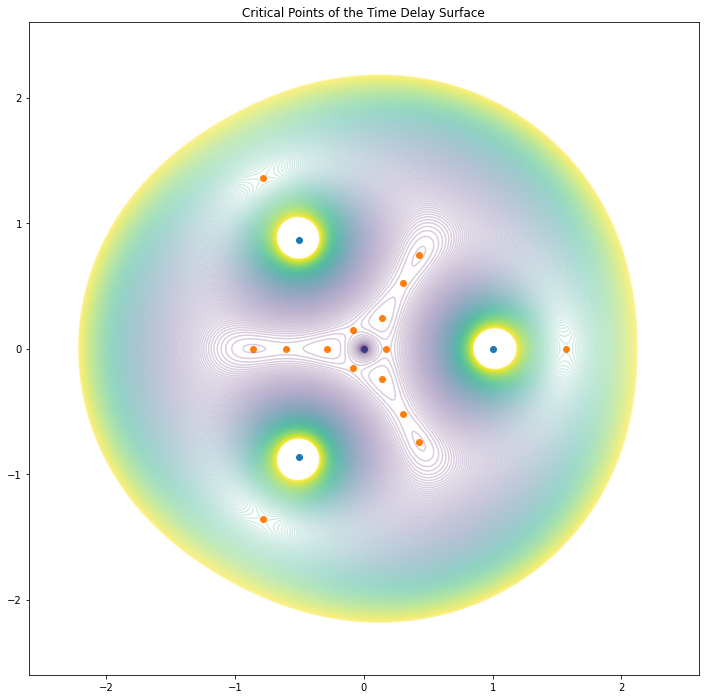

In [13]:
#Plot masses, potential surface, and critical points

fig, ax = plt.subplots()
ax.scatter(xix,xiy)

HP=.2
zmin=z.min()
zmax=z.max()
zmid=z.min()+HP*(z.max()-z.min())
grid1 = np.linspace(zmin,zmid,200)

plt.contour(X,Y,z,grid1,alpha=.2)

ax.scatter(zx,zy)

ax.set_title('Critical Points of the Time Delay Surface')
#ax.set_ylabel('Y')
#ax.set_xlabel('X')

#plt.colorbar()
plt.axis([-1*win,win,-1*win,win])
fig.set_size_inches(12, 12)

In [34]:
win

25.298221281347036

In [12]:
#Rhie Example
g=3
bm=.6
sm=.04
yy=[0.0,0.0]

xi,xix,xiy,m,win= CreateRhie(g,bm,sm,yy)

G1=1000
z,X,Y = CreatePointLensPotential(G1,win,yy,xi,m)

G0=100 
df_LensingMapSolns,zx,zy,zn,NSoln,cval = LensMapFSolveDF(G0,xi,xix,xiy,m, yy,win)

/home/bill/.conda/envs/lensing/lib/python3.8/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


In [41]:
#Weyl Example

#location of source
yy=[0,0]
#mass of points
mass=1.0
#number of masses
g=160

xi,xix,xiy,m,win = CreateWeylEnsemble(g,mass)

#G1=1000
#z,X,Y = CreatePointLensPotential(G1,win,yy,xi,m)

#G0=100 
#df_LensingMapSolns,zx,zy,zn,NSoln,cval = LensMapFSolveDF(G0,xi,xix,xiy,m,yy,win)


In [32]:
#Uniform Example

#location of source
yy=[0,0]
#mass of points
mass=1.0
#number of masses
g=160

xi,xix,xiy,m,win = CreateUnifEnsemble(g,mass)

#G1=1000
#z,X,Y = CreatePointLensPotential(G1,win,yy,xi,m)

#G0=100 
#df_LensingMapSolns,zx,zy,zn,NSoln,cval = LensMapFSolveDF(G0,xi,xix,xiy,m,yy,win)


In [245]:
#Sweep for initial size of G0
start_time = timeit.default_timer()

#location of source
yy=[0,0]
#mass of points
mass=1.0
#number of masses
g=160

df_G0vsNSolns=pd.DataFrame()
for l in range(5):
    #xi,xix,xiy,m,win = CreateUnifEnsemble(g,mass)
    #xi,xix,xiy,m,win = CreateWeylEnsemble(g,mass)
    for i in range(12):
        start_time = timeit.default_timer()

        G0=25*(i+1)
        df_LensingMapSolns,zx,zy,zn,NSoln,cval = LensMapFSolveDF(G0,xi,xix,xiy,m,yy,win)

        elapsed = timeit.default_timer() - start_time
        print(l,G0,elapsed)

        df_add=pd.DataFrame()
        df_add['l']=[l]
        df_add['g']=[g]
        df_add['G0']=[G0]
        df_add['time']=[elapsed]
        df_add['NSoln']=[NSoln]
        df_G0vsNSolns = df_G0vsNSolns.append(df_add,ignore_index=True)



/home/bill/.conda/envs/lensing/lib/python3.8/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/home/bill/.conda/envs/lensing/lib/python3.8/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


0 25 6.938421333034057
0 50 27.037583973957226
0 75 60.49274462001631
0 100 109.29768303298624
0 125 173.05803519603796
0 150 247.9417703670333
0 175 339.4225647569983
0 200 448.0174010330229
0 225 581.0239115510485
0 250 732.9670710070059
0 275 906.6951202549972
0 300 1108.7816843159962
1 25 6.724988738074899
1 50 27.655557370046154
1 75 61.65240439202171
1 100 110.08884627593216
1 125 177.02334474399686
1 150 253.22275389905553
1 175 347.7165221469477


KeyboardInterrupt: 

In [11]:
df_G0vsNSolns=pd.read_csv('df_G0vsNSolnsUnif160_0.csv')
df_G0vsNSolns

,Unnamed: 0,l,g,G0,time,NSoln
0,0,0,160,25,7.081825,87
1,1,0,160,50,27.850801,131
2,2,0,160,75,63.347147,148
3,3,0,160,100,111.775367,158
4,4,0,160,125,173.733372,164
5,5,0,160,150,253.711028,171
6,6,0,160,175,341.363070,171
7,7,0,160,200,455.204808,169
8,8,0,160,225,601.605248,171
9,9,0,160,250,770.116137,174


In [247]:
#Minimum distances between critical points and critical values
#P may be of interest in geometrically charactarizing Weyl vs Unif persistence

start_time = timeit.default_timer()

#location of source
yy=[0,0]
#mass of points
mass=1.0
#number of masses
g=160
#Fsolve initial conditions grid size
G0=200

df_MinDists=pd.DataFrame()
for l in range(16):
    start_time = timeit.default_timer()
    
    xi,xix,xiy,m,win = CreateUnifEnsemble(g,mass)
    #xi,xix,xiy,m,win = CreateWeylEnsemble(g,mass)
    
    df_LensingMapSoln,zx,zy,zn,NSoln,cval = LensMapFSolveDF(G0,xi,xix,xiy,m,yy,win)

    mincpd= min(scipy.spatial.distance.pdist(zn))
    
    cvl=np.array(cval).reshape(-1,1)
    mincvd = min(scipy.spatial.distance.pdist(cvl))
    mincv = min(cval)
    maxcv = max(cval)

    z,X,Y = CreatePointLensPotential(G1,win,yy,xi,m)
    zmin = z.min()
    zmax = z.max()
    
    P = (maxcv-mincv)/(zmax-zmin)
    
    df1=pd.DataFrame()
    df1['l']=[l]
    df1['g']=[g]
    df1['G0']=[G0]
    df1['G1']=[G1]
    df1['time']=[elapsed]
    df1['N']=[NSoln]
    df1['mincpd']=[mincpd]
    df1['mincvd']=[mincvd]
    df1['mincv']=[mincv]
    df1['maxcv']=[maxcv]
    df1['zmin']=[zmin]
    df1['zmax']=[zmax]
    df1['P']=[P]
    
    df_MinDists = df_MinDists.append(df1,ignore_index=True)
                 
    elapsed = timeit.default_timer() - start_time
    print(l,elapsed)

KeyboardInterrupt: 

In [12]:
#df_MinDists.to_csv('df_MinDistsUnif160_0.csv')
#df_MinDists.to_csv('df_MinDistsWeyl160_0.csv') 
df_MinDists=pd.read_csv('df_MinDistsWeyl160_L1.csv')
df_MinDists

,Unnamed: 0,l,g,G0,G1,time,N,mincpd,mincvd,mincv,maxcv,zmin,zmax,P
0,0,0,160,350,3000,84.220947,275,0.062157,0.000004,-328.765144,-255.825470,-328.765126,67.771631,0.183942
1,1,1,160,350,3000,84.320407,279,0.092218,0.000034,-328.781361,-316.929506,-328.781332,67.781542,0.029886
2,2,2,160,350,3000,84.263207,276,0.141388,0.000091,-329.425167,-186.520055,-329.425136,67.901014,0.359667
3,3,3,160,350,3000,84.144346,259,0.120523,0.000006,-328.385281,-313.833854,-328.385253,67.866343,0.036723
4,4,4,160,350,3000,83.975511,257,0.267328,0.000008,-328.577484,-314.563821,-328.577437,67.787460,0.035355
5,5,5,160,350,3000,84.176682,263,0.096198,0.000018,-328.575267,-315.317765,-328.575260,67.708125,0.033455
6,6,6,160,350,3000,83.928787,289,0.070269,0.000028,-329.471594,-83.807200,-329.471577,69.249140,0.616132
7,7,7,160,350,3000,83.970504,277,0.052466,0.000037,-328.502703,-292.838174,-328.502670,67.798426,0.089994
8,8,8,160,350,3000,84.132411,267,0.257916,0.000001,-328.538936,-291.534403,-328.538903,67.890838,0.093344
9,9,9,160,350,3000,84.424149,289,0.063318,0.000022,-328.732380,-296.913580,-328.732378,68.122554,0.080177


In [251]:
#Sweep for initial size of G1


#location of source
yy=[0,0]
#mass of points
mass=1.0
#number of masses
g=160

df_G1vsN=pd.DataFrame()
for l in range(36):
    #xi,xix,xiy,m,win = CreateUnifEnsemble(g,mass)
    xi,xix,xiy,m,win = CreateWeylEnsemble(g,mass)
    for i in range(20):
        start_time = timeit.default_timer()
        G1=100+100*i
        
        z,X,Y = CreatePointLensPotential(G1,win,yy,xi,m)

        df_Persistence,N0,N1,N,H0,H1 = CubicalPersistence(z,win)
        
        elapsed = timeit.default_timer() - start_time
        print(l,G1,elapsed)
        
        df_add=pd.DataFrame()
        df_add['l']=[l]
        df_add['g']=[g]
        df_add['G1']=[G1]
        df_add['G0']=[G0]
        df_add['time']=[elapsed]
        df_add['N']=[N]
        df_G1vsN = df_G1vsN.append(df_add,ignore_index=True)

0 100 0.40919765492435545
0 200 0.6485007790615782
0 300 1.1441867829998955
0 400 1.496501078014262
0 500 2.127459915005602
0 600 2.9197471420047805
0 700 4.052687510964461
0 800 5.128129262942821
0 900 6.472178434021771
0 1000 7.965132619952783
0 1100 9.580103373969905
0 1200 11.332415619050153
0 1300 13.455182145000435
0 1400 15.515587489004247
0 1500 17.956928691943176
0 1600 20.533906044089235
0 1700 23.080570494988933
0 1800 25.974123210995458
0 1900 29.132356599904597
0 2000 33.217272798065096
1 100 0.4336241080891341
1 200 0.6330595570616424
1 300 0.969683755072765
1 400 1.4697138749761507
1 500 2.13029374810867
1 600 2.9601088719209656
1 700 3.9690377070801333
1 800 5.106321395025589
1 900 6.521161337965168
1 1000 7.98573270405177
1 1100 9.686324893962592
1 1200 11.445848542032763
1 1300 13.545909320004284
1 1400 15.702382910996675
1 1500 18.028654794907197
1 1600 20.668208581977524
1 1700 23.188489058986306
1 1800 26.027344061993062
1 1900 29.05761221901048
1 2000 33.343974186

16 400 1.4782317969948053
16 500 2.124112161924131
16 600 2.9391427469672635
16 700 3.9483617229852825
16 800 5.088509800028987
16 900 6.447121542063542
16 1000 7.924871455994435
16 1100 9.59107998199761
16 1200 11.291847188957036
16 1300 13.397377196000889
16 1400 15.598511977936141
16 1500 17.743252799031325
16 1600 20.357612071093172
16 1700 22.847944632987492
16 1800 25.81941794999875
16 1900 28.664207686088048
16 2000 33.418220462976024
17 100 0.4232632910134271
17 200 0.6280800229869783
17 300 0.9730232789879665
17 400 1.4593832259997725
17 500 2.117069880012423
17 600 2.940522972960025
17 700 3.9485071189701557
17 800 5.094625725992955
17 900 6.4658375709550455
17 1000 7.933725128998049
17 1100 9.613745148060843
17 1200 11.348534523975104
17 1300 13.332042737980373
17 1400 15.432406101957895
17 1500 18.149722179048695
17 1600 20.406157929915935
17 1700 22.952700039953925
17 1800 25.84199158893898
17 1900 28.870181888109073
17 2000 32.99407620797865
18 100 0.4454977889545262
18 2

31 1800 25.80451785295736
31 1900 28.683733731973916
31 2000 33.18295065499842
32 100 0.4264640809269622
32 200 0.6301571569638327
32 300 0.9768314999528229
32 400 1.4661991100292653
32 500 2.1328603751026094
32 600 2.947745008044876
32 700 3.9412777359830216
32 800 5.070582993910648
32 900 6.385293630999513
32 1000 7.90274455701001
32 1100 9.530145711032674
32 1200 11.338876069057733
32 1300 13.252243699971586
32 1400 15.442222908022813
32 1500 17.906243338948116
32 1600 20.348351096035913
32 1700 22.85420676402282
32 1800 25.82301070704125
32 1900 28.716552954982035
32 2000 33.00930956704542
33 100 0.4433290290180594
33 200 0.6544447339838371
33 300 1.000642258906737
33 400 1.4865805739536881
33 500 2.1444023080402985
33 600 2.9571018340066075
33 700 3.9962896439246833
33 800 5.098442533053458
33 900 6.468172325054184
33 1000 7.922369698993862
33 1100 9.543710613041185
33 1200 11.415976627962664
33 1300 13.409084585960954
33 1400 15.413675043964759
33 1500 17.765534474048764
33 1600 

In [342]:
#Create sing set of linked dataframes

start_time = timeit.default_timer()

#location of source
yy=[0,0]
#mass of points
mass=1.0
#number of masses
g=150

#id
l=0

G0=400
G1=2000


df_LinkLocs=pd.DataFrame()
df_LinkPers=pd.DataFrame()
df_LinkNPers=pd.DataFrame()
df_LinkSolns=pd.DataFrame()

xi,xix,xiy,m,win = CreateUnifEnsemble(g,mass)
#xi,xix,xiy,m,win = CreateWeylEnsemble(g,mass)

z,X,Y = CreatePointLensPotential(G1,win,yy,xi,m)

df_Persistence,N0,N1,N,H0,H1 = CubicalPersistence(z,win)
df_Persistence['l']=l
df_Persistence['g']=g

df_LensingMapSoln,zx,zy,zn,NSoln,cval = LensMapFSolveDF(G0,xi,xix,xiy,m,yy,win)
df_LensingMapSoln['l']=l
df_LensingMapSoln['g']=g

df_Locs=pd.DataFrame()
for i in range(g):
    df=pd.DataFrame()                            
    df['l']=[l]
    df['g']=[g]
    df['G0']=[G0]
    df['G1']=[G1]
    df['xi']=[xi[i]]
    df_Locs = df_Locs.append(df,ignore_index=True)

df_NPers=pd.DataFrame()

df_NPers['l']=[l]
df_NPers['g']=[g]
df_NPers['G0']=[G0]
df_NPers['G1']=[G1]
df_NPers['N']=[N]
df_NPers['NSoln']=[NSoln]
df_NPers['N0']=[N0]
df_NPers['N1']=[N1]
df_NPers['H0']=[H0]
df_NPers['H1']=[H1]

df_LinkLocs=df_LinkLocs.append(df_Locs,ignore_index=True)
df_LinkPers=df_LinkPers.append(df_Persistence,ignore_index=True)
df_LinkNPers=df_LinkNPers.append(df_NPers,ignore_index=True)
df_LinkSolns=df_LinkSolns.append(df_LensingMapSoln,ignore_index=True)

elapsed = timeit.default_timer() - start_time
print(elapsed)


        

/home/bill/.conda/envs/lensing/lib/python3.8/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
/home/bill/.conda/envs/lensing/lib/python3.8/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


2185.705505951075


In [460]:
#Linked sweep for initial size of G0, G1, Min dist btw cp/cv

start_time = timeit.default_timer()

#location of source
yy=[0,0]
#mass of points
mass=1.0
#number of masses
g=160

df_G0vsNSolns=pd.DataFrame()
df_G1vsN=pd.DataFrame()

df_MinDists=pd.DataFrame()

df_LinkLocs=pd.DataFrame()
df_LinkPers=pd.DataFrame()
df_LinkNPers=pd.DataFrame()
df_LinkSolns=pd.DataFrame()

for l in range(16):
    start_time_0 = timeit.default_timer()
    #xi,xix,xiy,m,win = CreateUnifEnsemble(g,mass)
    xi,xix,xiy,m,win = CreateWeylEnsemble(g,mass)
    
    #G0 sweep
    for i in range(7):
        start_time = timeit.default_timer()

        G0=50*(i+1)
        df_LensingMapSoln,zx,zy,zn,NSoln,cval = LensMapFSolveDF(G0,xi,xix,xiy,m,yy,win)
        df_LensingMapSoln['l']=l

        elapsed = timeit.default_timer() - start_time
        print(l,'G0=',G0,elapsed)

        df0=pd.DataFrame()
        df0['l']=[l]
        df0['g']=[g]
        df0['G0']=[G0]
        df0['time']=[elapsed]
        df0['NSoln']=[NSoln]
        df_G0vsNSolns = df_G0vsNSolns.append(df0,ignore_index=True)
    
    #G1 Sweep
    for i in range(30):
        start_time = timeit.default_timer()
        G1=100+100*i
        
        z,X,Y = CreatePointLensPotential(G1,win,yy,xi,m)

        df_Persistence,N0,N1,N,H0,H1 = CubicalPersistence(z,win)
        df_Persistence['l']=l
        df_Persistence['g']=g        
        df_Persistence['G1']=G1
        
        elapsed = timeit.default_timer() - start_time
        print(l,'G1=',G1,elapsed)
        
        df1=pd.DataFrame()
        df1['l']=[l]
        df1['g']=[g]
        df1['G1']=[G1]
        df1['time']=[elapsed]
        df1['N']=[N]
        df_G1vsN = df_G1vsN.append(df1,ignore_index=True)
    
    #Mindist info
    start_time = timeit.default_timer()
    mincpd= min(scipy.spatial.distance.pdist(zn))
    cvl=np.array(cval).reshape(-1,1)
    mincvd = min(scipy.spatial.distance.pdist(cvl))
    mincv = min(cval)
    maxcv = max(cval)
    zmin = z.min()
    zmax = z.max()
    P = (maxcv-mincv)/(zmax-zmin)
    
    df2=pd.DataFrame()
    df2['l']=[l]
    df2['g']=[g]
    df2['G0']=[G0]
    df2['G1']=[G1]
    df2['time']=[elapsed]
    df2['N']=[NSoln]
    df2['mincpd']=[mincpd]
    df2['mincvd']=[mincvd]
    df2['mincv']=[mincv]
    df2['maxcv']=[maxcv]
    df2['zmin']=[zmin]
    df2['zmax']=[zmax]
    df2['P']=[P]
    
    df_MinDists = df_MinDists.append(df2,ignore_index=True)

    #Record ensemble
    df_Locs=pd.DataFrame()
    for i in range(g):
        df3=pd.DataFrame()                            
        df3['l']=[l]
        df3['g']=[g]
        df3['xi']=[xi[i]]
        df_Locs = df_Locs.append(df3,ignore_index=True)

    
    df_NPers=pd.DataFrame()

    df_NPers['l']=[l]
    df_NPers['g']=[g]
    df_NPers['G0']=[G0]
    df_NPers['G1']=[G1]
    df_NPers['N']=[N]
    df_NPers['NSoln']=[NSoln]
    df_NPers['N0']=[N0]
    df_NPers['N1']=[N1]
    df_NPers['H0']=[H0]
    df_NPers['H1']=[H1]

    df_LinkLocs=df_LinkLocs.append(df_Locs,ignore_index=True)
    df_LinkPers=df_LinkPers.append(df_Persistence,ignore_index=True)
    df_LinkNPers=df_LinkNPers.append(df_NPers,ignore_index=True)
    df_LinkSolns=df_LinkSolns.append(df_LensingMapSoln,ignore_index=True)

    elapsed = timeit.default_timer() - start_time_0
    print(l,elapsed)

0 G0= 50 31.443184345960617
0 G0= 100 123.22301410394721
0 G0= 150 275.88298225286417
0 G0= 200 498.600398740964
0 G0= 250 814.4058517289814
0 G0= 300 1225.4475488918833
0 G0= 350 1757.458284121938
0 G1= 100 0.40605078893713653
0 G1= 200 0.631454013986513
0 G1= 300 0.9765129189472646
0 G1= 400 1.458133971085772
0 G1= 500 2.1075601240154356
0 G1= 600 2.9554858880583197
0 G1= 700 3.8995620710775256
0 G1= 800 4.9854132540058345
0 G1= 900 6.252570648910478
0 G1= 1000 7.671860219910741
0 G1= 1100 9.304269833955914
0 G1= 1200 11.007032223977149
0 G1= 1300 12.99382078112103
0 G1= 1400 14.924811002099887
0 G1= 1500 17.255439029773697
0 G1= 1600 19.64447705098428
0 G1= 1700 22.068002267973498
0 G1= 1800 24.940133093856275
0 G1= 1900 28.356091943802312
0 G1= 2000 31.85883391997777
0 G1= 2100 38.67537581990473
0 G1= 2200 44.47682531015016
0 G1= 2300 48.84568738704547
0 G1= 2400 53.20402880012989
0 G1= 2500 58.05050429212861
0 G1= 2600 62.38685414590873
0 G1= 2700 67.5376512950752
0 G1= 2800 73.17

7 G1= 1400 14.969502875814214
7 G1= 1500 17.236517837038264
7 G1= 1600 19.57452416513115
7 G1= 1700 22.21554359002039
7 G1= 1800 25.179203163832426
7 G1= 1900 27.885487237013876
7 G1= 2000 32.217253332957625
7 G1= 2100 39.51672190008685
7 G1= 2200 45.02049814001657
7 G1= 2300 49.16377258906141
7 G1= 2400 53.53584167314693
7 G1= 2500 57.76032545813359
7 G1= 2600 62.518124300055206
7 G1= 2700 67.47082355199382
7 G1= 2800 72.8385853129439
7 G1= 2900 78.1970658081118
7 G1= 3000 83.970503997989
7 5660.976746153086
8 G0= 50 30.777816341957077
8 G0= 100 124.07443860685453
8 G0= 150 280.47962257103063
8 G0= 200 511.74741210904904
8 G0= 250 818.3815168431029
8 G0= 300 1230.9235444669612
8 G0= 350 1777.126793748932
8 G1= 100 0.42268421105109155
8 G1= 200 0.6215170319192111
8 G1= 300 0.9691360630095005
8 G1= 400 1.4592470079660416
8 G1= 500 2.1160791479051113
8 G1= 600 2.920959130860865
8 G1= 700 3.889400174142793
8 G1= 800 4.987520417198539
8 G1= 900 6.276813208125532
8 G1= 1000 7.68739262199960

14 G1= 2700 71.49477654881775
14 G1= 2800 76.58391119213775
14 G1= 2900 81.74152257293463
14 G1= 3000 85.41482676705346
14 5904.592546507018
15 G0= 50 30.910281725926325
15 G0= 100 126.07474533491768
15 G0= 150 284.5861076589208
15 G0= 200 508.54057276109233
15 G0= 250 837.8067955549341
15 G0= 300 1301.5424650039058
15 G0= 350 1829.3874497718643
15 G1= 100 0.44880769588053226
15 G1= 200 0.6533197059761733
15 G1= 300 0.9930622051469982
15 G1= 400 1.4775517291855067
15 G1= 500 2.136317530879751
15 G1= 600 3.0500489259138703
15 G1= 700 4.094222873216495
15 G1= 800 5.44390769302845
15 G1= 900 6.605981151107699
15 G1= 1000 8.129399318015203
15 G1= 1100 9.850185109069571
15 G1= 1200 11.740547810913995
15 G1= 1300 13.527785324957222
15 G1= 1400 15.840177592122927
15 G1= 1500 17.986963098868728
15 G1= 1600 20.608446310972795
15 G1= 1700 23.206014657160267
15 G1= 1800 26.73316489206627
15 G1= 1900 29.63468910707161
15 G1= 2000 33.81569663295522
15 G1= 2100 41.43354858295061
15 G1= 2200 48.44279

In [470]:

#df_G0vsNSolns.to_csv('df_G0vsNSolnsWeyl160_L1.csv') 

#df_G1vsN.to_csv('df_G1vsNWeyl160_L1.csv') 
 
#df_MinDists.to_csv('df_MinDistsWeyl160_L1.csv')

#df_LinkLocs.to_csv('df_LinkLocsWeyl160_L1.csv') 

#df_LinkPers.to_csv('df_LinkPersWeyl160_L1.csv') 

#df_LinkNPers.to_csv('df_LinkNPersWeyl160_L.csv')  

#df_LinkSolns.to_csv('df_LinkSolnsWeyl160_L1.csv') 

#df_G0vsNSolns
#df_G1vsN
#df_MinDists
#df_LinkLocs
#df_LinkPers
#df_LinkNPers
#df_LinkSolns

In [46]:
df_G0vsNSolns = pd.read_csv('df_G0vsNSolnsWeyl160_L1.csv')
df_G1vsN = pd.read_csv('df_G1vsNWeyl160_L1.csv')
df_MinDists = pd.read_csv('df_MinDistsWeyl160_L1.csv')
df_LinkLocs = pd.read_csv('df_LinkLocsWeyl160_L1.csv')
df_LinkPers = pd.read_csv('df_LinkPersWeyl160_L1.csv')
df_LinkNPers = pd.read_csv('df_LinkNPersWeyl160_L1.csv')
df_LinkSolns = pd.read_csv('df_LinkSolnsWeyl160_L1.csv')

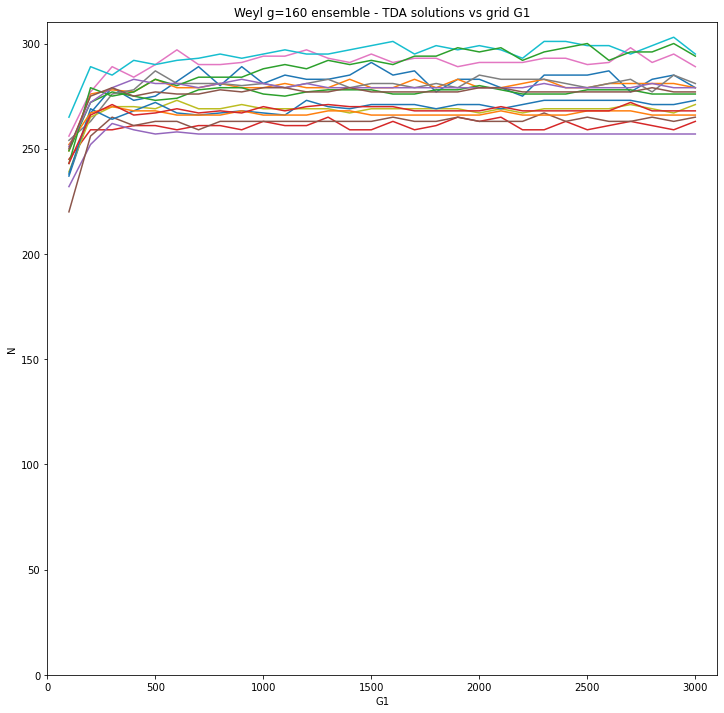

In [47]:
fig, ax = plt.subplots()

groups=df_G1vsN.groupby('l')

for name, group in groups:
    ax.plot(group.G1, group.N, label=name)

plt.axis([0,3100,0,310])
ax.set_title('Weyl g=160 ensemble - TDA solutions vs grid G1')
ax.set_ylabel('N')
ax.set_xlabel('G1')

fig.set_size_inches(12, 12)

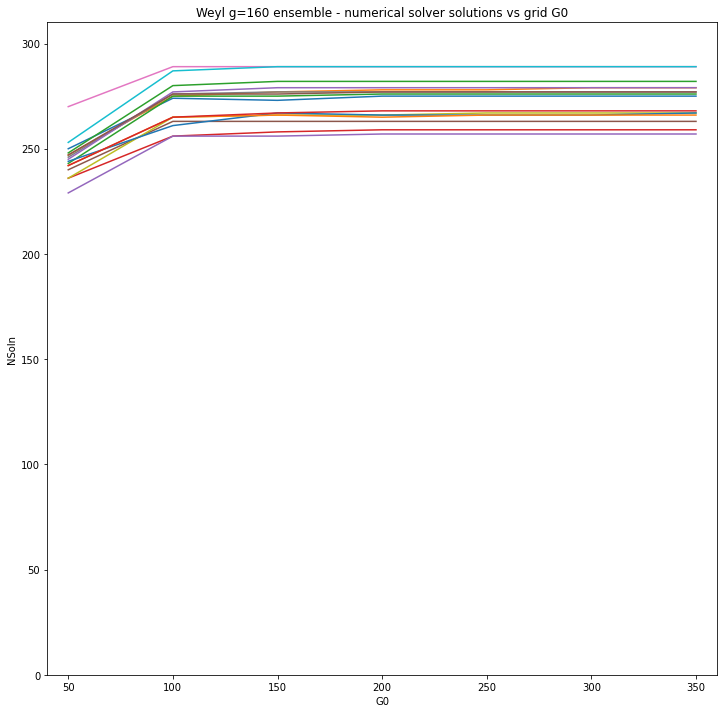

In [48]:
fig, ax = plt.subplots()

groups=df_G0vsNSolns.groupby('l')

for name, group in groups:
    ax.plot(group.G0, group.NSoln, label=name)

plt.axis([40,360,0,310])
ax.set_title('Weyl g=160 ensemble - numerical solver solutions vs grid G0')
ax.set_ylabel('NSoln')
ax.set_xlabel('G0')

fig.set_size_inches(12, 12)

In [171]:
df_G0vsNSolns = pd.read_csv('df_G0vsNSolnsUnif160_L1.csv')
df_G1vsN = pd.read_csv('df_G1vsNUnif160_L1.csv')
df_MinDists = pd.read_csv('df_MinDistsUnif160_L1.csv')
df_LinkLocs = pd.read_csv('df_LinkLocsUnif160_L1.csv')
df_LinkPers = pd.read_csv('df_LinkPersUnif160_L1.csv')
df_LinkNPers = pd.read_csv('df_LinkNPersUnif160_L1.csv')
df_LinkSolns = pd.read_csv('df_LinkSolnsUnif160_L1.csv')

In [172]:
df_MinDists


,Unnamed: 0,l,g,G0,G1,time,NSolns,mincpd,mincvd,mincv,maxcv,zmin,zmax,P
0,0,0,160,350,3000,83.450773,180,0.237472,0.000105,-333.584976,-303.978114,-333.584935,70.518541,0.073266
1,1,1,160,350,3000,84.215674,176,0.186572,0.000279,-334.245177,-313.054681,-334.245149,69.028943,0.052546
2,2,2,160,350,3000,83.038563,178,0.316150,0.000012,-346.469542,-305.895851,-346.469525,71.287109,0.097123
3,3,3,160,350,3000,83.538242,184,0.253079,0.000181,-341.244563,-306.318077,-341.244521,71.730801,0.084573
4,4,4,160,350,3000,83.052721,163,0.269930,0.000076,-340.890945,-307.077734,-340.890928,70.816751,0.082129
5,5,5,160,350,3000,83.082789,170,0.209538,0.000096,-352.183581,-305.685848,-352.183553,72.913974,0.109381
6,6,6,160,350,3000,82.976287,185,0.223310,0.000128,-335.821488,-308.827245,-335.821483,69.987169,0.066520
7,7,7,160,350,3000,82.332099,178,0.069353,0.000163,-338.555019,-302.399408,-338.554999,71.555701,0.088161
8,8,8,160,350,3000,95.355861,171,0.019483,0.000003,-337.629630,-306.441174,-337.629583,70.324432,0.076451
9,9,9,160,350,3000,95.071790,180,0.016695,0.000004,-342.048707,-309.108768,-342.048691,69.473666,0.080044


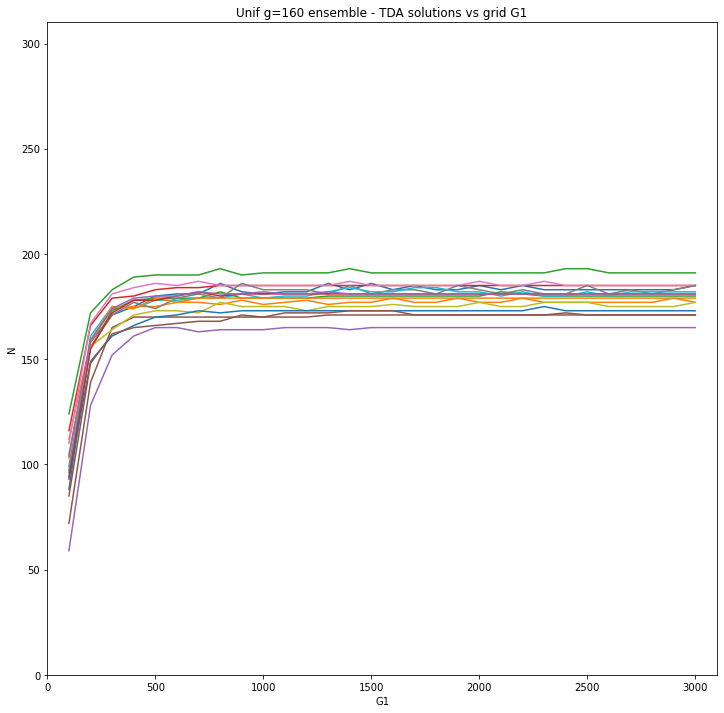

In [50]:
fig, ax = plt.subplots()

groups=df_G1vsN.groupby('l')

for name, group in groups:
    ax.plot(group.G1, group.N, label=name)

plt.axis([0,3100,0,310])
ax.set_title('Unif g=160 ensemble - TDA solutions vs grid G1')
ax.set_ylabel('N')
ax.set_xlabel('G1')

fig.set_size_inches(12, 12)

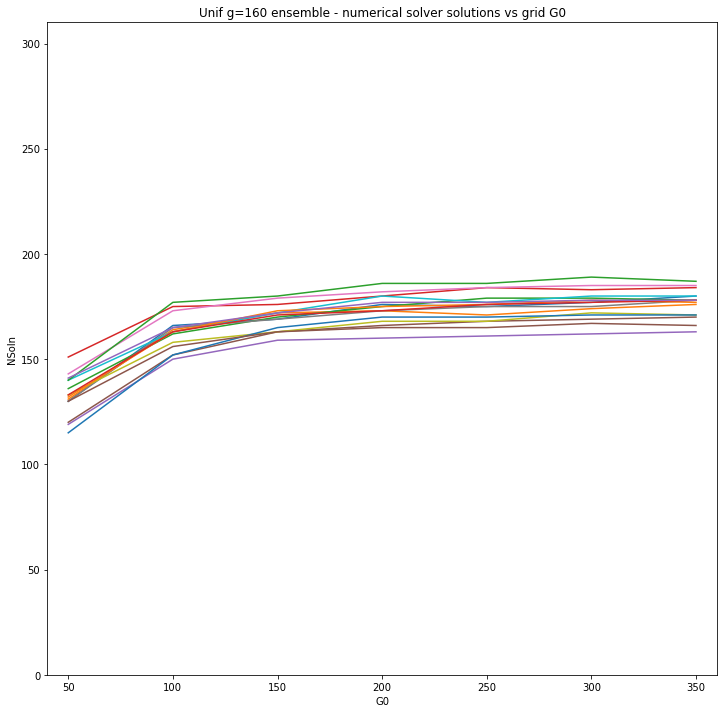

In [51]:
fig, ax = plt.subplots()

groups=df_G0vsNSolns.groupby('l')

for name, group in groups:
    ax.plot(group.G0, group.NSoln, label=name)
    

plt.axis([40,360,0,310])
ax.set_title('Unif g=160 ensemble - numerical solver solutions vs grid G0')
ax.set_ylabel('NSoln')
ax.set_xlabel('G0')

fig.set_size_inches(12, 12)

In [52]:
#df_G0vsNSolns
#df_G1vsN
#df_MinDists
#df_LinkLocs
#df_LinkPers
#df_LinkNPers
#df_LinkSolns

,Unnamed: 0,g,G0,win,zn,zx,zy,cval,l
0,0,160,350,25.298221,[ -3.78290264 -11.4892179 ],-3.782903,-11.489218,-325.470434,0
1,1,160,350,25.298221,[-5.06900208 -9.61574382],-5.069002,-9.615744,-323.640536,0
2,2,160,350,25.298221,[-5.86670041 -9.9391302 ],-5.866700,-9.939130,-323.894690,0
3,3,160,350,25.298221,[-11.62370955 -2.29587203],-11.623710,-2.295872,-333.584976,0
4,4,160,350,25.298221,[-9.73294745 1.62509207],-9.732947,1.625092,-327.616085,0
...,...,...,...,...,...,...,...,...,...
2817,2817,160,350,25.298221,[ 9.69370642 -0.63859722],9.693706,-0.638597,-307.297658,15
2818,2818,160,350,25.298221,[ 9.38739731 -1.33272431],9.387397,-1.332724,-309.042227,15
2819,2819,160,350,25.298221,[8.18362723 7.93127393],8.183627,7.931274,-308.081395,15
2820,2820,160,350,25.298221,[ 8.60544134 -6.41396663],8.605441,-6.413967,-311.295226,15


In [368]:
#Big TDA run

start_time = timeit.default_timer()

#location of source
yy=[0,0]
#mass of points
mass=1.0

G1=2000

df_BigPers=pd.DataFrame()
df_NBigPers=pd.DataFrame()
for l in range(100):
    for g in range(10,161,10):
        #xi,xix,xiy,m,win = CreateUnifEnsemble(g,mass)
        xi,xix,xiy,m,win = CreateWeylEnsemble(g,mass)
            
        z,X,Y = CreatePointLensPotential(G1,win,yy,xi,m)

        df_Persistence,N0,N1,N,H0,H1 = CubicalPersistence(z,win)
        df_Persistence['g']=g
        df_Persistence['l']=l
        df_Persistence['G1']=G1
        
        df_NPers=pd.DataFrame()
        df_NPers['l']=[l]
        df_NPers['g']=[g]
        df_NPers['N']=[N]
        df_NPers['N0']=[N0]
        df_NPers['N1']=[N1]
        df_NPers['H0']=[H0]
        df_NPers['H1']=[H1]
        df_NPers['G1']=[G1]
        
        df_BigPers=df_BigPers.append(df_Persistence,ignore_index=True)
        df_NBigPers=df_NBigPers.append(df_NPers,ignore_index=True)

        elapsed = timeit.default_timer() - start_time
        print(l,g,elapsed)
        

0 10 15.648384812055156
0 20 32.18497143802233
0 30 49.849359608022496
0 40 70.24175306607503
0 50 90.42803868209012
0 60 111.3796432610834
0 70 133.64147931803018
0 80 156.79911115800496
0 90 181.1096272750292
0 100 206.68633382907137
0 110 233.19853953202255
0 120 260.9617851501098
0 130 289.94598094502
0 140 319.947230835096
0 150 350.9197254900355
0 160 383.1504849510966
1 10 398.6301808010321
1 20 415.2526214810787
1 30 433.01334723702166
1 40 451.9423520551063
1 50 471.95425872609485
1 60 492.98640765901655
1 70 515.109152988065
1 80 538.3913412520196
1 90 562.8146257130429
1 100 588.3100172310369
1 110 614.8015736381058
1 120 642.4489960230421
1 130 671.44754487311
1 140 701.545172495069
1 150 732.6067755121039
1 160 764.8083086180268
2 10 780.2532291420503
2 20 797.0459664210211
2 30 814.9243050310761
2 40 833.8339532969985
2 50 853.8336442690343
2 60 874.905118339113
2 70 897.0836843970465
2 80 920.4780941490317
2 90 944.8871850770665
2 100 970.3236620350508
2 110 997.05366637

21 50 8118.758371224045
21 60 8139.872404908063
21 70 8162.120418210048
21 80 8185.330932298093
21 90 8209.797007286106
21 100 8235.424155992107
21 110 8262.146284601069
21 120 8289.903346275096
21 130 8318.689936307026
21 140 8348.7137259281
21 150 8379.81271585403
21 160 8412.092400911031
22 10 8427.684303001035
22 20 8444.403512280085
22 30 8462.270138300024
22 40 8481.198450193042
22 50 8501.177639369038
22 60 8522.237210054998
22 70 8544.484473753022
22 80 8567.909306642017
22 90 8592.305634059012
22 100 8618.15301393508
22 110 8644.809514100081
22 120 8672.660025466
22 130 8701.468434519018
22 140 8731.605098532047
22 150 8762.575433617109
22 160 8794.851672802004
23 10 8810.339872698998
23 20 8827.089202919044
23 30 8844.963740065112
23 40 8863.87379183108
23 50 8883.795953050023
23 60 8904.907724781078
23 70 8927.143163980101
23 80 8950.512562761083
23 90 8975.083544573048
23 100 9000.731657683034
23 110 9027.384505500086
23 120 9055.231673056027
23 130 9084.197361345054
23 140

41 140 16007.314126943005
41 150 16038.568005925044
41 160 16070.647436877014
42 10 16086.149471964105
42 20 16103.041042920086
42 30 16120.887200518046
42 40 16139.784790785052
42 50 16159.743667953066
42 60 16180.8888094211
42 70 16203.064143604017
42 80 16226.475968864048
42 90 16250.783318249043
42 100 16276.634088640101
42 110 16303.40830722102
42 120 16331.10052194004
42 130 16360.112558841007
42 140 16390.10933972604
42 150 16421.403825734043
42 160 16453.730610025
43 10 16469.263318968005
43 20 16486.030963265104
43 30 16503.92156432511
43 40 16522.9929952221
43 50 16543.03859555407
43 60 16564.146235067048
43 70 16586.455319203087
43 80 16609.743878225097
43 90 16634.341024863068
43 100 16660.02188316104
43 110 16687.136242594104
43 120 16714.97174861806
43 130 16743.865703749005
43 140 16773.903708344093
43 150 16804.910118561005
43 160 16837.18261888402
44 10 16852.634446374024
44 20 16869.287919907016
44 30 16887.16395475308
44 40 16906.108022726025
44 50 16926.09069526207


62 60 23830.545254315017
62 70 23852.86095679202
62 80 23876.286412583082
62 90 23900.828139601042
62 100 23926.390049796086
62 110 23953.271042933105
62 120 23981.146927011083
62 130 24010.08892629505
62 140 24040.150371846044
62 150 24071.2579319661
62 160 24103.589200628106
63 10 24119.055019220104
63 20 24135.68200009002
63 30 24153.50998800411
63 40 24172.319747934
63 50 24192.24149693607
63 60 24213.36002379202
63 70 24235.56680666702
63 80 24258.795068002073
63 90 24283.09351139504
63 100 24308.6196428861
63 110 24335.34550704807
63 120 24363.213604101096
63 130 24392.0799334771
63 140 24422.057006266084
63 150 24453.390901200008
63 160 24485.611582763027
64 10 24501.019859414082
64 20 24517.681728668045
64 30 24535.433939279057
64 40 24554.349802106037
64 50 24574.382450451027
64 60 24595.557907184004
64 70 24617.67404577101
64 80 24641.007418034016
64 90 24665.454960601055
64 100 24691.137270223
64 110 24717.867011238006
64 120 24745.645272112102
64 130 24774.413209394086
64 1

82 150 31717.199113939074
82 160 31749.322084360057
83 10 31765.005206974107
83 20 31781.708644959028
83 30 31799.579307446023
83 40 31818.348375851056
83 50 31838.331804968067
83 60 31859.481723267003
83 70 31881.75830302108
83 80 31905.02819970611
83 90 31929.500615469064
83 100 31955.21364612202
83 110 31982.06367176911
83 120 32009.92371928005
83 130 32038.70448585204
83 140 32068.6752413481
83 150 32099.78455762507
83 160 32131.89097438508
84 10 32147.312100186013
84 20 32163.99832601007
84 30 32181.863092451007
84 40 32200.891341031063
84 50 32220.837731291074
84 60 32241.89422572509
84 70 32264.08847442502
84 80 32287.479616378085
84 90 32311.812558142003
84 100 32337.439077440067
84 110 32364.373738779104
84 120 32392.208231363096
84 130 32421.17275118211
84 140 32451.23456817807
84 150 32482.444921114016
84 160 32514.584653837024
85 10 32530.044067273033
85 20 32546.86532045901
85 30 32564.604935117997
85 40 32583.491582946037
85 50 32603.548496778007
85 60 32624.58021117607
8

In [491]:
#df_BigPers.to_csv('df_UnifBigPers_0.csv')
#df_NBigPers.to_csv('df_UnifNBigPers_0.csv')
#df_NBigPers

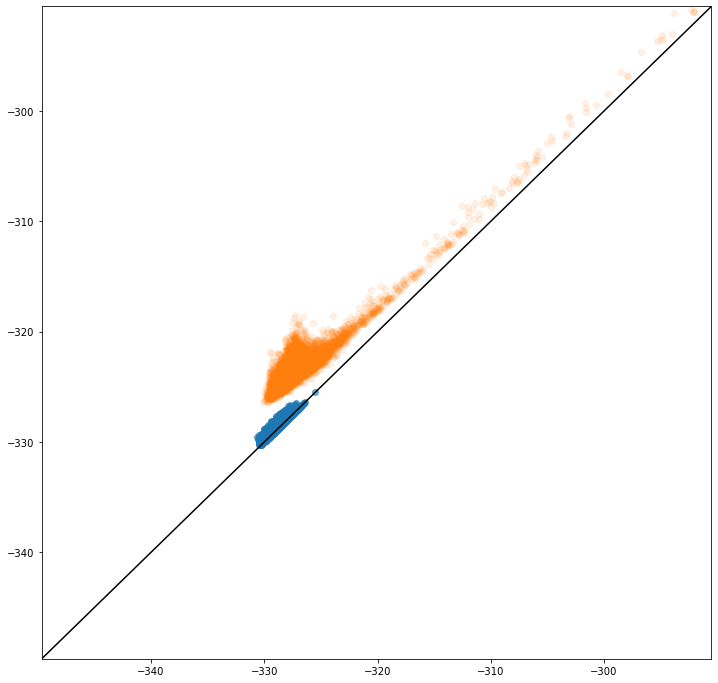

In [74]:
df_BigPers = pd.read_csv('df_WeylBigPers_0.csv')

fig, ax = plt.subplots()

g=160

x0 = df_BigPers[(df_BigPers['index']==0)&(df_BigPers['g']==g)]['birth'].values
y0 = df_BigPers[(df_BigPers['index']==0)&(df_BigPers['g']==g)]['death'].values
x1 = df_BigPers[(df_BigPers['index']==1)&(df_BigPers['g']==g)]['birth'].values
y1 = df_BigPers[(df_BigPers['index']==1)&(df_BigPers['g']==g)]['death'].values


y0[y0==np.inf]= max(max(y0[y0!=np.inf]),max(y1[y1!=np.inf]))
#y0[y0==np.inf]= max(y1[y1!=np.inf]
y1[y1==np.inf]= max(max(y0[y0!=np.inf]),max(y1[y1!=np.inf]))


ax.scatter(x0,y0, alpha=.6) 
ax.scatter(x1,y1,  alpha=.1)                                 

#Mx = max(max(x0),max(x1),max(y0), max(y1))
#Mx = -1.5*g
#mx = min(min(x0),min(x1),min(y0),min(y1))

x = np.linspace(mx,Mx,2000)


ax.plot(x,x,'k')

plt.xlim([mx, Mx])
plt.ylim([mx,Mx])

#plt.axis([-1*win,win,-1*win,win])

fig.set_size_inches(12, 12)


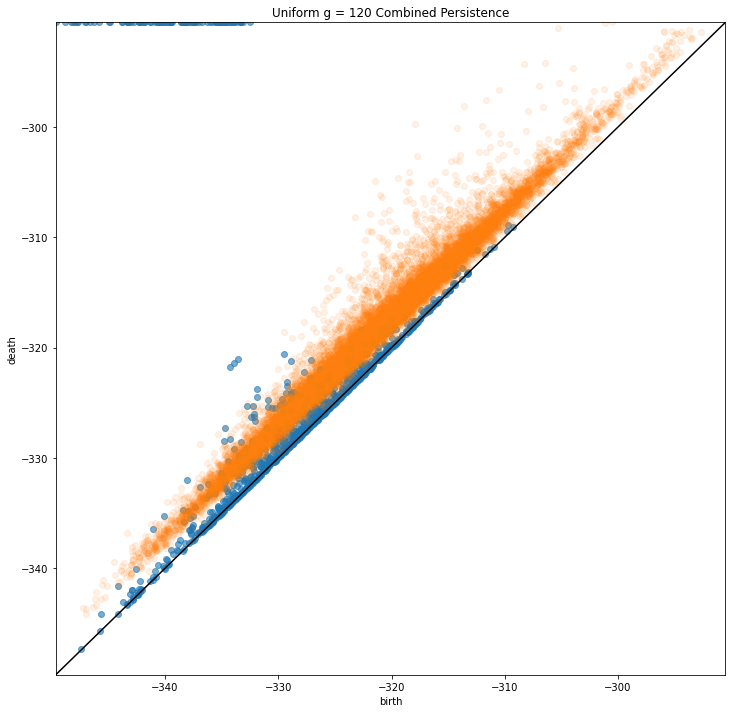

In [73]:
df_BigPers = pd.read_csv('df_UnifBigPers_0.csv')

fig, ax = plt.subplots()

g=160

x0 = df_BigPers[(df_BigPers['index']==0)&(df_BigPers['g']==g)]['birth'].values
y0 = df_BigPers[(df_BigPers['index']==0)&(df_BigPers['g']==g)]['death'].values
x1 = df_BigPers[(df_BigPers['index']==1)&(df_BigPers['g']==g)]['birth'].values
y1 = df_BigPers[(df_BigPers['index']==1)&(df_BigPers['g']==g)]['death'].values

y0[y0==np.inf]= max(max(y0[y0!=np.inf]),max(y1[y1!=np.inf]))
#y0[y0==np.inf]= max(y1[y1!=np.inf]
y1[y1==np.inf]= max(max(y0[y0!=np.inf]),max(y1[y1!=np.inf]))


ax.scatter(x0,y0,alpha=.6) 
ax.scatter(x1,y1,alpha=.1)                                 

Mx = max(max(x0),max(x1),max(y0), max(y1))
mx = min(min(x0),min(x1),min(y0),min(y1))

x = np.linspace(mx,Mx,2000)


ax.plot(x,x,'k')

ax.set_title('Uniform g = 120 Combined Persistence')
ax.set_ylabel('death')
ax.set_xlabel('birth')

plt.xlim([mx, Mx])
plt.ylim([mx,Mx])
#plt.xlim([mx,-315])
#plt.ylim([mx,-315])

fig.set_size_inches(12, 12)

<function matplotlib.pyplot.show(close=None, block=None)>

<Figure size 2280x1520 with 0 Axes>

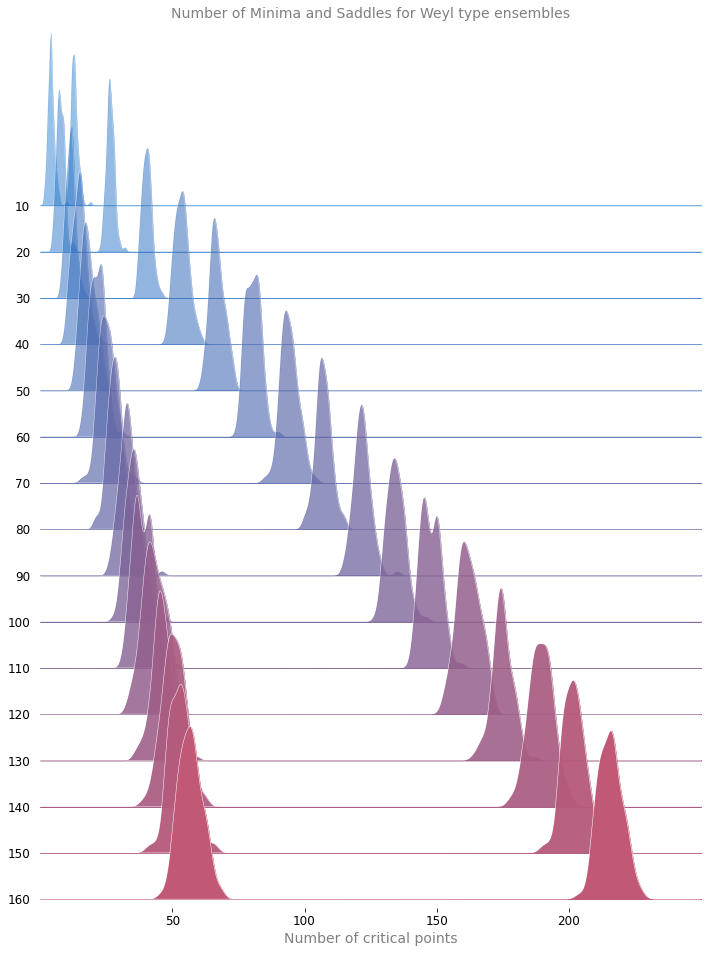

In [537]:
#set some display options
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

#create a color gradent function to be used in the colormap parameter
def color_gradient(x=0.0, start=(0, 0, 0), stop=(1, 1, 1)):
    r = np.interp(x, [0, 1], [start[0], stop[0]])
    g = np.interp(x, [0, 1], [start[1], stop[1]])
    b = np.interp(x, [0, 1], [start[2], stop[2]])
    return (r, g, b)

#plot the figure
plt.figure(dpi=380)
df1=pd.read_csv('df_WeylNBigPers_0.csv')
fig, axes = joypy.joyplot(df1
                          , column=['N0', 'N1']
                          , overlap=2.5
                          , by="g"
                          , ylim='own'
                          , x_range=(0,250)
                          , fill=True
                          , figsize=(10,13)
                          , legend=False
                          , xlabels=True
                          , ylabels=True
                          #, color=['#76a5af', '#134f5c']
                          , colormap=lambda x: color_gradient(x, start=(.08, .45, .8)
                                                             ,stop=(.8, .34, .44))
                          , alpha=0.6
                          , linewidth=.5
                          , linecolor='w'
                          #, background='k' # change to 'k' for black background or 'grey' for grey
                          , fade=True)
plt.title('Number of Minima and Saddles for Weyl type ensembles'
          , fontsize=14
          , color='grey'
          , alpha=1)
plt.rc("font", size=12)
plt.xlabel('Number of critical points', fontsize=14, color='grey', alpha=1)
plt.ylabel('Number of masses', fontsize=8, color='grey', alpha=1)
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

<Figure size 2280x1520 with 0 Axes>

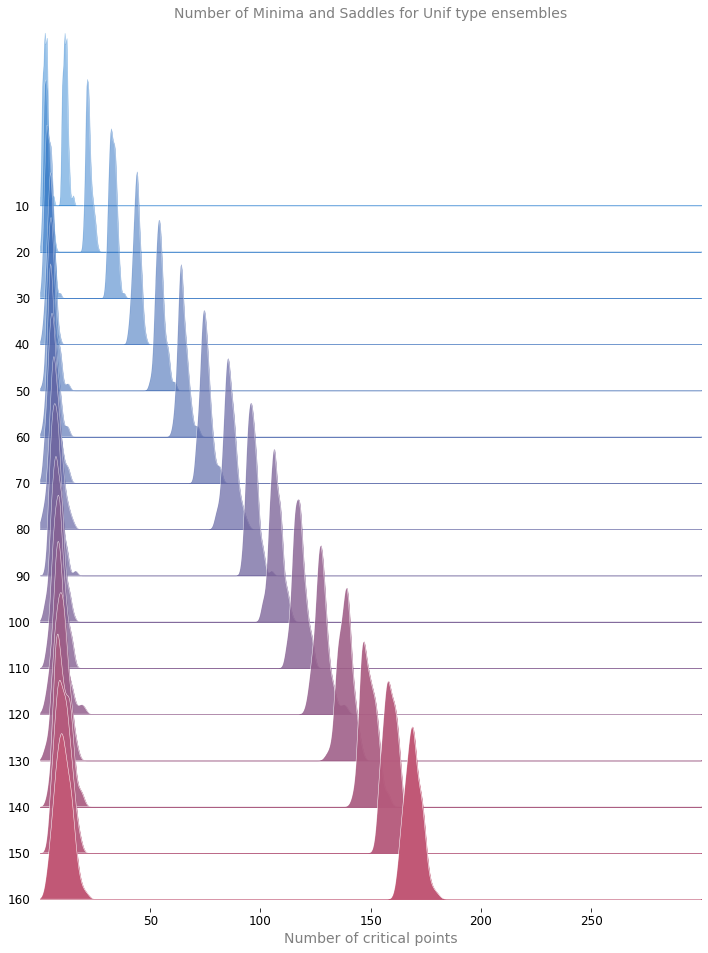

In [538]:
#set some display options
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

#create a color gradent function to be used in the colormap parameter
def color_gradient(x=0.0, start=(0, 0, 0), stop=(1, 1, 1)):
    r = np.interp(x, [0, 1], [start[0], stop[0]])
    g = np.interp(x, [0, 1], [start[1], stop[1]])
    b = np.interp(x, [0, 1], [start[2], stop[2]])
    return (r, g, b)

#plot the figure
plt.figure(dpi=380)
df1=df_NBigPers = pd.read_csv('df_UnifNBigPers_0.csv')
fig, axes = joypy.joyplot(df1
                          , column=['N0', 'N1']
                          , overlap=2.5
                          , by="g"
                          , ylim='own'
                          , x_range=(0,300)
                          , fill=True
                          , figsize=(10,13)
                          , legend=False
                          , xlabels=True
                          , ylabels=True
                          #, color=['#76a5af', '#134f5c']
                          , colormap=lambda x: color_gradient(x, start=(.08, .45, .8)
                                                             ,stop=(.8, .34, .44))
                          , alpha=0.6
                          , linewidth=.5
                          , linecolor='w'
                          #, background='k' # change to 'k' for black background or 'grey' for grey
                          , fade=True)
plt.title('Number of Minima and Saddles for Uniform type ensembles'
          , fontsize=14
          , color='grey'
          , alpha=1)
plt.rc("font", size=12)
plt.xlabel('Number of critical points', fontsize=14, color='grey', alpha=1)
plt.ylabel('Number of masses', fontsize=8, color='grey', alpha=1)
plt.show

In [97]:
#One full example

yy=[0,0]
mass=1.0
g=160

G0=200
G1=2000

xi,xix,xiy,m,win = CreateUnifEnsemble(g,mass)
#xi,xix,xiy,m,win = CreateWeylEnsemble(g,mass)

z,X,Y = CreatePointLensPotential(G1,win,yy,xi,m)

#df_LensingMapSolns,zx,zy,zn,NSoln,cval = LensMapFSolveDF(G0,xi,xix,xiy,m,yy,win)

df_Persistence,N0,N1,N,H0,H1 = CubicalPersistence(z,win)

#print(NSoln,N,N0,N1,H0,H1)




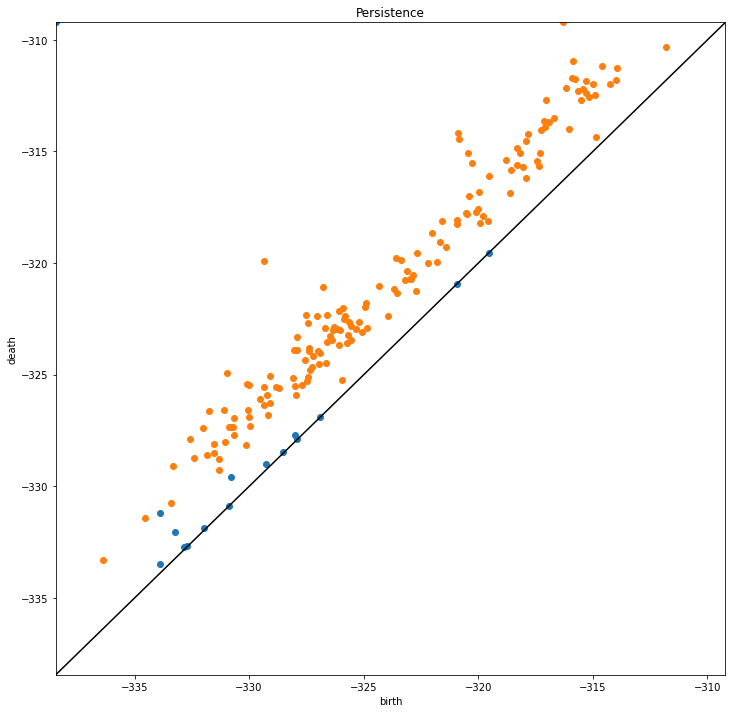

In [102]:
fig, ax = plt.subplots()

x0 = df_Persistence[df_Persistence['index']==0]['birth'].values
y0 = df_Persistence[df_Persistence['index']==0]['death'].values
x1 = df_Persistence[df_Persistence['index']==1]['birth'].values
y1 = df_Persistence[df_Persistence['index']==1]['death'].values

#y0[y0==np.inf]= max(max(y0[y0!=np.inf]),max(y1[y1!=np.inf]))
y0[y0==np.inf]= max(y1[y1!=np.inf])
y1[y1==np.inf]= max(max(y0[y0!=np.inf]),max(y1[y1!=np.inf]))


ax.scatter(x0,y0) 
ax.scatter(x1,y1)                                 

Mx = max(max(x0),max(x1),max(y0), max(y1))
mx = min(min(x0),min(x1),min(y0),min(y1))

x = np.linspace(mx,Mx,2000)
ax.plot(x,x,'k')

ax.set_title('Persistence')
ax.set_ylabel('death')
ax.set_xlabel('birth')

plt.axis([mx,Mx, mx, Mx])
fig.set_size_inches(12, 12)


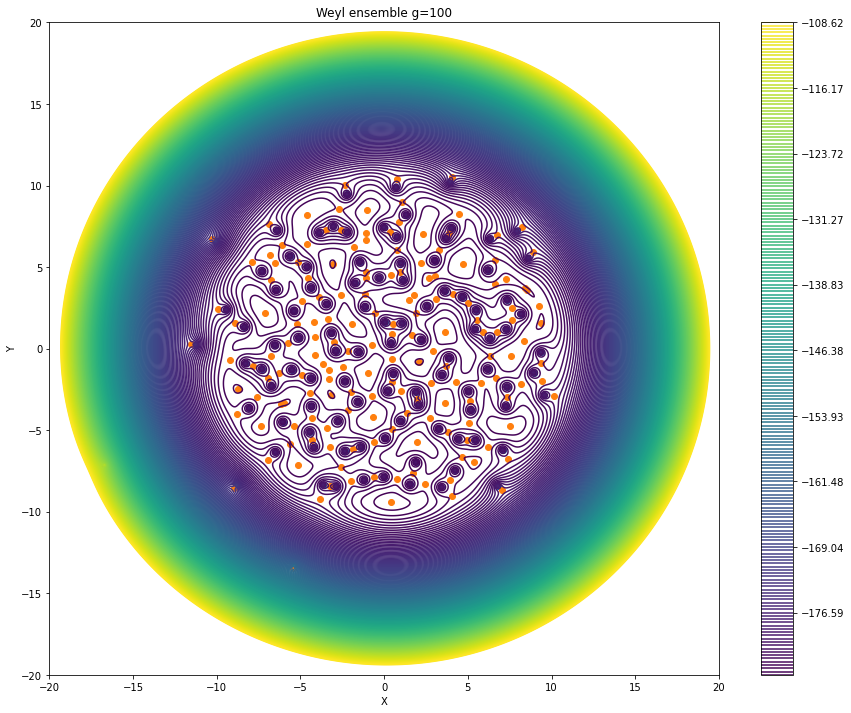

In [109]:
#Plot masses, potential surface, and critical points

fig, ax = plt.subplots()


HP=.3
zmin=z.min()
zmax=z.max()
zmid=z.min()+HP*(z.max()-z.min())
grid1 = np.linspace(zmin,zmid,200)

plt.contour(X,Y,z,grid1)
ax.scatter(xix,xiy)
#ax.scatter(zx2,zy2)
ax.scatter(zx,zy)

ax.set_title('Weyl ensemble g=100')
ax.set_ylabel('Y')
ax.set_xlabel('X')

plt.colorbar()
fig.set_size_inches(15, 12)


In [ ]:
#Weyl roots stats

def GenWeylRoots(g):
    mu, sigma = 0,1 
    n = np.random.randn(g+1, 2).view(np.complex128) 
    c = np.ones(g+1)
    for i in range(g+1):
        c[i] = 1/np.sqrt(float(np.math.factorial(i)))
    c = c.reshape(g+1,1)
    N = np.multiply(c,n) 

    r = np.roots(N[::-1].reshape(g+1,))
    s = [x.real for x in r]
    t = [x.imag for x in r]
    xi = np.stack((s,t),axis=1)
    return xi,N 

def LogBigRoots(xi,g):
    RtDist = np.sqrt(np.add(np.square(xi[:,0]),np.square(xi[:,1])))
    recloc = []
    for i in range(len(xi)):
        if RtDist[i]>2*g**.5:
            recloc = np.append(recloc,i)
    return recloc

def LogMedRoots(xi,g):
    RtDist = np.sqrt(np.add(np.square(xi[:,0]),np.square(xi[:,1])))
    recloc = []
    for i in range(len(xi)):
        if RtDist[i]<=2*g**.5:
            recloc = np.append(recloc,i)
    return recloc

def LogSmallRoots(xi,g):
    RtDist = np.sqrt(np.add(np.square(xi[:,0]),np.square(xi[:,1])))
    recloc = []
    for i in range(len(xi)):
        if RtDist[i]<=g**.5:
            recloc = np.append(recloc,i)
    return recloc

In [16]:


start_time = timeit.default_timer()
df_WeylRoots = pd.DataFrame()
df_RootCounter = pd.DataFrame()
df_RootStats = pd.DataFrame()
grange=171
lrange=1000
for g in range(10,grange,10):
    for l in range(lrange):
        xi,N = GenWeylRoots(g)
        for i in range(g):
            df = pd.DataFrame()
            df['l']=[l]
            df['g']=[g]
            df['xi']=[xi[i]]
            df['coefs']=[N]
            df_WeylRoots = df_WeylRoots.append(df,ignore_index=True)
            
        recloc2 = LogBigRoots(xi,g)
        recloc1 = LogMedRoots(xi,g)
        recloc0 = LogSmallRoots(xi,g)
        df0 = pd.DataFrame()
        df0['l']=[l]
        df0['g']=[g]
        df0['R']=[g**.5]
        df0['%<=R']=[len(recloc0)/g]
        df0['%<=2R']=[len(recloc1)/g]
        df0['%>2R']=[len(recloc2)/g]
        df_RootCounter = df_RootCounter.append(df0,ignore_index=True)
        
        elapsed = timeit.default_timer() - start_time
        print(elapsed,g,l)
    df1=pd.DataFrame()
    df1['g']=[g]
    df1['min %<=R']=[min(df_RootCounter[df_RootCounter['g']==g]['%<=R'].values)]
    df1['max %<=R']=[max(df_RootCounter[df_RootCounter['g']==g]['%<=R'].values)]    
    df1['avg %<=R']=[np.mean(df_RootCounter[df_RootCounter['g']==g]['%<=R'].values)]
    df1['min %<=2R']=[min(df_RootCounter[df_RootCounter['g']==g]['%<=2R'].values)]
    df1['max %<=2R']=[max(df_RootCounter[df_RootCounter['g']==g]['%<=2R'].values)]    
    df1['avg %<=2R']=[np.mean(df_RootCounter[df_RootCounter['g']==g]['%<=2R'].values)]
    df1['min %>2R']=[min(df_RootCounter[df_RootCounter['g']==g]['%>2R'].values)]
    df1['max %>2R']=[max(df_RootCounter[df_RootCounter['g']==g]['%>2R'].values)]    
    df1['avg %>2R']=[np.mean(df_RootCounter[df_RootCounter['g']==g]['%>2R'].values)]
    df_RootStats = df_RootStats.append(df1,ignore_index=True)


df_WeylRoots.to_csv('df_WeylRoots.csv')
df_RootCounter.to_csv('df_RootCounter.csv')
df_RootStats.to_csv('df_RootStats.csv')

0.03118900302797556 10 0
0.060887278988957405 10 1
0.09671899187378585 10 2
0.12662602099590003 10 3
0.15176234603859484 10 4
0.17564229294657707 10 5
0.19932731101289392 10 6
0.22258149995468557 10 7
0.2465809490531683 10 8
0.2748288318980485 10 9
0.29929146892391145 10 10
0.3226471699308604 10 11
0.34694550302810967 10 12
0.37045736890286207 10 13
0.3942102550063282 10 14
0.4178998819552362 10 15
0.44156415201723576 10 16
0.46530035603791475 10 17
0.49393865489400923 10 18
0.5178455740679055 10 19
0.5414090000558645 10 20
0.5650574630126357 10 21
0.5888458739500493 10 22
0.6124089248478413 10 23
0.6362471650354564 10 24
0.6611736500635743 10 25
0.6866956970188767 10 26
0.7115163628477603 10 27
0.7396279519889504 10 28
0.7633109460584819 10 29
0.7878169070463628 10 30
0.8125493710394949 10 31
0.8437616438604891 10 32
0.8754787440411747 10 33
0.910111143020913 10 34
0.9454664080403745 10 35
0.980922857997939 10 36
1.0159267240669578 10 37
1.051741163013503 10 38
1.0894854459911585 10 3

8.798779567936435 10 328
8.826485276920721 10 329
8.850546590983868 10 330
8.874699336942285 10 331
8.898599850945175 10 332
8.922294355928898 10 333
8.945981449913234 10 334
8.969662977848202 10 335
8.9934007730335 10 336
9.021295514889061 10 337
9.049769627861679 10 338
9.073905023979023 10 339
9.09800110803917 10 340
9.121843226952478 10 341
9.14612458506599 10 342
9.170622064033523 10 343
9.194562677992508 10 344
9.218469904968515 10 345
9.24696942884475 10 346
9.274741186993197 10 347
9.29866630397737 10 348
9.322364816907793 10 349
9.346153876977041 10 350
9.370033330982551 10 351
9.393897610949352 10 352
9.417654677061364 10 353
9.441335771000013 10 354
9.466424830956385 10 355
9.497032806044444 10 356
9.521985672879964 10 357
9.545798746868968 10 358
9.569563136901706 10 359
9.593953914940357 10 360
9.617737306980416 10 361
9.64235475892201 10 362
9.666089660022408 10 363
9.694672656944022 10 364
9.723813578952104 10 365
9.748370732879266 10 366
9.772928857943043 10 367
9.79728

17.915938994847238 10 656
17.940869124839082 10 657
17.965255388990045 10 658
17.98941161786206 10 659
18.013560029910877 10 660
18.03777230391279 10 661
18.06204568501562 10 662
18.086308161960915 10 663
18.110571844968945 10 664
18.138594263931736 10 665
18.164142702007666 10 666
18.188431364949793 10 667
18.21273079700768 10 668
18.237017638981342 10 669
18.261307526845485 10 670
18.285489305853844 10 671
18.309625681955367 10 672
18.333860808052123 10 673
18.362780279945582 10 674
18.387770511908457 10 675
18.412095071049407 10 676
18.436401584884152 10 677
18.46072543086484 10 678
18.48494039196521 10 679
18.509214218938723 10 680
18.53343071299605 10 681
18.557683755876496 10 682
18.586313396925107 10 683
18.611500666011125 10 684
18.635797173017636 10 685
18.660258810035884 10 686
18.68457386083901 10 687
18.70887430687435 10 688
18.733120797900483 10 689
18.757353388005868 10 690
18.781586969969794 10 691
18.810729691991583 10 692
18.835779019864276 10 693
18.86002288898453 10 

25.988990584854037 10 977
26.0141651739832 10 978
26.03881780290976 10 979
26.06347609590739 10 980
26.088104900904 10 981
26.112872425932437 10 982
26.13756907195784 10 983
26.162314546993002 10 984
26.18699185200967 10 985
26.21745296800509 10 986
26.242488329997286 10 987
26.267202286049724 10 988
26.29213182395324 10 989
26.317024156916887 10 990
26.34159019496292 10 991
26.36623795586638 10 992
26.391014683060348 10 993
26.415758947841823 10 994
26.445752799045295 10 995
26.47091053589247 10 996
26.49565395596437 10 997
26.52027031290345 10 998
26.544996079988778 10 999
26.59951304504648 20 0
26.64600465586409 20 1
26.698101362911984 20 2
26.744533007964492 20 3
26.790955991018564 20 4
26.839178442023695 20 5
26.885963812004775 20 6
26.937836613040417 20 7
26.984552087029442 20 8
27.030934773851186 20 9
27.077572390902787 20 10
27.123936486896127 20 11
27.176435024943203 20 12
27.22319846902974 20 13
27.269652254879475 20 14
27.316180204972625 20 15
27.36266614194028 20 16
27.4151

41.52453077584505 20 307
41.57301492593251 20 308
41.62088506203145 20 309
41.66872801305726 20 310
41.716536562889814 20 311
41.7722565990407 20 312
41.820936135947704 20 313
41.86919678095728 20 314
41.91776550002396 20 315
41.965881757903844 20 316
42.020987276919186 20 317
42.0692002158612 20 318
42.11739631998353 20 319
42.16553206485696 20 320
42.21360121201724 20 321
42.2683041410055 20 322
42.31651867902838 20 323
42.36448367405683 20 324
42.41251334594563 20 325
42.46063788002357 20 326
42.51590101700276 20 327
42.56396624306217 20 328
42.61200759396888 20 329
42.66008548694663 20 330
42.70823528105393 20 331
42.763625097926706 20 332
42.81182708591223 20 333
42.86014425405301 20 334
42.90839865896851 20 335
42.95639256294817 20 336
43.01148346206173 20 337
43.05971690895967 20 338
43.107945307856426 20 339
43.15609643096104 20 340
43.20410611387342 20 341
43.25932993693277 20 342
43.30751605401747 20 343
43.35573497903533 20 344
43.40387853397988 20 345
43.452144532930106 20 

58.41811777791008 20 635
58.472166226943955 20 636
58.525357346981764 20 637
58.580179292941466 20 638
58.638805642025545 20 639
58.70341801387258 20 640
58.756378252990544 20 641
58.81187637406401 20 642
58.87735225702636 20 643
58.9451266550459 20 644
59.00449765101075 20 645
59.05536124086939 20 646
59.113727889955044 20 647
59.168742961017415 20 648
59.21913121198304 20 649
59.269533902872354 20 650
59.333230572985485 20 651
59.41292000003159 20 652
59.493527696002275 20 653
59.57531795394607 20 654
59.65861867996864 20 655
59.74106013099663 20 656
59.824605306843296 20 657
59.90793144493364 20 658
59.98905407683924 20 659
60.07098923390731 20 660
60.13732396089472 20 661
60.19635953800753 20 662
60.253751259995624 20 663
60.32096607098356 20 664
60.38207621499896 20 665
60.43869149289094 20 666
60.490578192984685 20 667
60.547528127906844 20 668
60.61209189891815 20 669
60.66529902885668 20 670
60.71869086404331 20 671
60.77473777392879 20 672
60.836921942885965 20 673
60.89220673

78.7303638679441 20 965
78.80604182486422 20 966
78.87100350204855 20 967
78.93483842001297 20 968
79.01608353387564 20 969
79.08428123197518 20 970
79.16050335485488 20 971
79.24847577605397 20 972
79.33586630993523 20 973
79.4232942420058 20 974
79.50192957487889 20 975
79.56128689902835 20 976
79.62034549284726 20 977
79.70691401697695 20 978
79.79251779592596 20 979
79.87262671487406 20 980
79.94212542101741 20 981
80.01664742291905 20 982
80.07433794392273 20 983
80.13005848391913 20 984
80.19493660400622 20 985
80.26309919403866 20 986
80.33105974504724 20 987
80.38787181302905 20 988
80.45495745493099 20 989
80.51292220596224 20 990
80.56914712605067 20 991
80.63123572804034 20 992
80.71621238486841 20 993
80.78792230202816 20 994
80.85561898886226 20 995
80.91692977189086 20 996
80.99211225192994 20 997
81.06234961003065 20 998
81.14031401905231 20 999
81.25395082798786 30 0
81.38241572794504 30 1
81.49043120793067 30 2
81.5877915439196 30 3
81.67016008403152 30 4
81.7638993370

110.23042918788269 30 295
110.33192901895382 30 296
110.42707183491439 30 297
110.52563212485984 30 298
110.61992163397372 30 299
110.71208453294821 30 300
110.8046001449693 30 301
110.89431576197967 30 302
110.99944872199558 30 303
111.1392824749928 30 304
111.27276575705037 30 305
111.37505151191726 30 306
111.47731649084017 30 307
111.57752073789015 30 308
111.6720349448733 30 309
111.76615732302889 30 310
111.85918118502013 30 311
111.95897751697339 30 312
112.06204387685284 30 313
112.20209036394954 30 314
112.34010651195422 30 315
112.46290266700089 30 316
112.57991710398346 30 317
112.69231623387896 30 318
112.7950029920321 30 319
112.89294731197879 30 320
112.99541481002234 30 321
113.11130007891916 30 322
113.22549999994226 30 323
113.32631953898817 30 324
113.42366804089397 30 325
113.5237576670479 30 326
113.62343241903 30 327
113.72078674496152 30 328
113.82036218885332 30 329
113.91924387705512 30 330
114.01794087793678 30 331
114.12307809083723 30 332
114.23616064991802 3

142.30646053585224 30 613
142.41452076705173 30 614
142.52306746994145 30 615
142.63116698293015 30 616
142.7373076849617 30 617
142.84543880284764 30 618
142.9538762490265 30 619
143.06123007601127 30 620
143.1701286728494 30 621
143.2782234440092 30 622
143.38616055785678 30 623
143.49435318796895 30 624
143.60197954904288 30 625
143.7096598308999 30 626
143.81861332897097 30 627
143.92755274893716 30 628
144.0342461350374 30 629
144.14185153786093 30 630
144.2499085299205 30 631
144.35853090696037 30 632
144.46937927091494 30 633
144.57934377295896 30 634
144.68834857805632 30 635
144.79737860593013 30 636
144.90801680088043 30 637
145.0196557128802 30 638
145.13114705402404 30 639
145.24082772806287 30 640
145.35365252988413 30 641
145.46595750004053 30 642
145.57896491885185 30 643
145.69212124799378 30 644
145.80596175906248 30 645
145.91924951598048 30 646
146.03452077903785 30 647
146.14966597990133 30 648
146.2656354769133 30 649
146.38137525506318 30 650
146.4981387029402 30 

179.2051473229658 30 933
179.3293933130335 30 934
179.4532953898888 30 935
179.5758886630647 30 936
179.69851764896885 30 937
179.8214334489312 30 938
179.9448033280205 30 939
180.06738669984043 30 940
180.19080486800522 30 941
180.31328374589793 30 942
180.43775286595337 30 943
180.56118182395585 30 944
180.68474898091517 30 945
180.80681447987445 30 946
180.93059526593424 30 947
181.05275518097915 30 948
181.1774609980639 30 949
181.30138437403366 30 950
181.42671401705593 30 951
181.54954788391478 30 952
181.67362140095793 30 953
181.79668164695613 30 954
181.92042370396666 30 955
182.04342435486615 30 956
182.16738865105435 30 957
182.29179102997296 30 958
182.41675779991783 30 959
182.54052389995195 30 960
182.66471101995558 30 961
182.78745902492665 30 962
182.91160878306255 30 963
183.03564539994113 30 964
183.16231834399514 30 965
183.28612397098914 30 966
183.41088908491656 30 967
183.53449394996278 30 968
183.65986472694203 30 969
183.7835944229737 30 970
183.90798442903906 3

232.3363371428568 40 257
232.51699569402263 40 258
232.7004240108654 40 259
232.88329823198728 40 260
233.0654349559918 40 261
233.2473460799083 40 262
233.43034564494155 40 263
233.6116648700554 40 264
233.79476583003998 40 265
233.9773796480149 40 266
234.16028895694762 40 267
234.34263680689037 40 268
234.52619403298013 40 269
234.70939998701215 40 270
234.8932460239157 40 271
235.07640986703336 40 272
235.26013534306549 40 273
235.4431497619953 40 274
235.6278659128584 40 275
235.8109328339342 40 276
235.99459708994254 40 277
236.17954644793645 40 278
236.36387699493207 40 279
236.54667872190475 40 280
236.730145416921 40 281
236.9128952580504 40 282
237.0964463769924 40 283
237.2798201770056 40 284
237.46513690589927 40 285
237.64902673102915 40 286
237.83270144392736 40 287
238.0156657579355 40 288
238.19959842902608 40 289
238.38396110292524 40 290
238.56858952599578 40 291
238.75273873098195 40 292
238.93730815290473 40 293
239.1209612248931 40 294
239.3054253780283 40 295
239.

298.46521361288615 40 579
298.6700935889967 40 580
298.8735152978916 40 581
299.0811565099284 40 582
299.29428178584203 40 583
299.5080528820399 40 584
299.71445875195786 40 585
299.92199519998394 40 586
300.12604384100996 40 587
300.33042359096 40 588
300.55974478391 40 589
300.7861431159545 40 590
300.99419497395866 40 591
301.20590196200646 40 592
301.41320057888515 40 593
301.6169163209852 40 594
301.8294884939678 40 595
302.03843654692173 40 596
302.25098920590244 40 597
302.4606734800618 40 598
302.6659206780605 40 599
302.8743548069615 40 600
303.07984287198633 40 601
303.2860210079234 40 602
303.4979454900604 40 603
303.7036290150136 40 604
303.9175900190603 40 605
304.12319161091 40 606
304.33260119496845 40 607
304.54086575703695 40 608
304.75057207606733 40 609
304.96795905195177 40 610
305.1750120308716 40 611
305.37889497797005 40 612
305.5878664168995 40 613
305.785558270989 40 614
305.9852601690218 40 615
306.19282833393663 40 616
306.3937859418802 40 617
306.59807224199

371.8976201089099 40 903
372.1341398500372 40 904
372.37216638284735 40 905
372.6095678920392 40 906
372.84546671784483 40 907
373.08387187402695 40 908
373.32021585688926 40 909
373.5623609840404 40 910
373.8042294490151 40 911
374.0412635358516 40 912
374.2779437259305 40 913
374.51388817699626 40 914
374.75347842788324 40 915
374.9905192148872 40 916
375.22783341794275 40 917
375.46710278396495 40 918
375.6997986440547 40 919
375.9430500320159 40 920
376.18251172592863 40 921
376.4238386978395 40 922
376.65836711088195 40 923
376.8991019979585 40 924
377.14084452483803 40 925
377.388688076986 40 926
377.62890593498014 40 927
377.87370859389193 40 928
378.11102046095766 40 929
378.35216466896236 40 930
378.5935758878477 40 931
378.8343125069514 40 932
379.0747603739146 40 933
379.3113493898418 40 934
379.5523916480597 40 935
379.79351096600294 40 936
380.0351982668508 40 937
380.27284340700135 40 938
380.51396201504394 40 939
380.7548334458843 40 940
380.9888390949927 40 941
381.2318

468.7657002939377 50 230
469.08790233987384 50 231
469.4087722739205 50 232
469.7307055538986 50 233
470.050828197971 50 234
470.37334428192116 50 235
470.69676374597475 50 236
471.0394512580242 50 237
471.3586845570244 50 238
471.67838695296086 50 239
471.9973956779577 50 240
472.3150647149887 50 241
472.63570067705587 50 242
472.97975813783705 50 243
473.38974334998056 50 244
473.7207692388911 50 245
474.05238133785315 50 246
474.384792632889 50 247
474.76754849986173 50 248
475.1019727808889 50 249
475.4384201520588 50 250
475.7632496589795 50 251
476.0880609329324 50 252
476.42035760288127 50 253
476.7426019490231 50 254
477.0665082889609 50 255
477.3978568559978 50 256
477.7412344380282 50 257
478.11710833502 50 258
478.4449213258922 50 259
478.7899083029479 50 260
479.13919575489126 50 261
479.49449956184253 50 262
479.8167888249736 50 263
480.1744726288598 50 264
480.5315830600448 50 265
480.8595175289083 50 266
481.2372461310588 50 267
481.57564390893094 50 268
481.921951026888

581.5452567238826 50 558
581.958513055928 50 559
582.3445380649064 50 560
582.7671493589878 50 561
583.1530356130097 50 562
583.533059027046 50 563
583.9200287689455 50 564
584.2951591890305 50 565
584.6721509709023 50 566
585.0515581490472 50 567
585.4260531908367 50 568
585.8175019328482 50 569
586.2047654478811 50 570
586.5881889259908 50 571
586.972497388022 50 572
587.3553228320088 50 573
587.7372632338665 50 574
588.1154202849139 50 575
588.4951634178869 50 576
588.8767496868968 50 577
589.259853629861 50 578
589.634825529065 50 579
590.0137500269338 50 580
590.3965786439367 50 581
590.7782415079419 50 582
591.1568419509567 50 583
591.5384178720415 50 584
591.9102989009116 50 585
592.2944960428867 50 586
592.6786235768814 50 587
593.0538116300013 50 588
593.4341454170644 50 589
593.8096815838944 50 590
594.1829769799951 50 591
594.5592615730129 50 592
594.9360240600072 50 593
595.3090356569737 50 594
595.686598917935 50 595
596.0608585840091 50 596
596.4339396660216 50 597
596.81

711.3052209578454 50 888
711.7201766578946 50 889
712.1365437859204 50 890
712.5517062689178 50 891
712.9679790169466 50 892
713.3746860940009 50 893
713.7927047179546 50 894
714.1994863059372 50 895
714.613286879845 50 896
715.0338156360667 50 897
715.445689786924 50 898
715.8532416729722 50 899
716.2627286638599 50 900
716.6736898859963 50 901
717.0826036748476 50 902
717.4934456420597 50 903
717.8980267548468 50 904
718.3047790259589 50 905
718.7134664449841 50 906
719.1207241569646 50 907
719.529156220844 50 908
719.9366327950265 50 909
720.3445147909224 50 910
720.7511837049387 50 911
721.1585500158835 50 912
721.5694478070363 50 913
722.0335529239383 50 914
722.5224777448457 50 915
722.9594547450542 50 916
723.3681995158549 50 917
723.7885949958581 50 918
724.202533609001 50 919
724.6132290170062 50 920
725.0384295950644 50 921
725.4470635589678 50 922
725.8569834199734 50 923
726.2658730000257 50 924
726.6749061569571 50 925
727.0833433850203 50 926
727.4905479999725 50 927
727.

875.037543065846 60 222
875.5761774189305 60 223
876.1206524849404 60 224
876.6546431959141 60 225
877.1881079338491 60 226
877.7238603918813 60 227
878.2575527019799 60 228
878.7918295168784 60 229
879.335285078967 60 230
879.8817208388355 60 231
880.4217906179838 60 232
880.9630047478713 60 233
881.5030633579008 60 234
882.1383654910605 60 235
882.6932073698845 60 236
883.2218303929549 60 237
883.7540835868567 60 238
884.2872830219567 60 239
884.8151110310573 60 240
885.3457869200502 60 241
885.8769953448791 60 242
886.4107034199405 60 243
886.9389265128411 60 244
887.4692946788855 60 245
888.0465719569474 60 246
888.6726968388539 60 247
889.2717666060198 60 248
889.8894326209556 60 249
890.5188955869526 60 250
891.1630511879921 60 251
891.803822056856 60 252
892.4365389798768 60 253
893.0884713670239 60 254
893.7291404749267 60 255
894.3313930160366 60 256
894.8757138629444 60 257
895.4171076819766 60 258
896.0035000368953 60 259
896.574335479876 60 260
897.107348036021 60 261
897.6

1054.1589184340555 60 548
1054.7179699549451 60 549
1055.2791316949297 60 550
1055.8343296879902 60 551
1056.3922931780107 60 552
1056.9512063160073 60 553
1057.5139730940573 60 554
1058.0702461828478 60 555
1058.6296992478892 60 556
1059.1879463929217 60 557
1059.749107212061 60 558
1060.3133459750097 60 559
1060.8720853989944 60 560
1061.436498790048 60 561
1062.0025278429966 60 562
1062.5668949228711 60 563
1063.1190340858884 60 564
1063.6681283030193 60 565
1064.2178410559427 60 566
1064.783055523876 60 567
1065.3464070179034 60 568
1065.9081472980324 60 569
1066.4673829309177 60 570
1067.0309295048937 60 571
1067.5961063548457 60 572
1068.157453036867 60 573
1068.7154517590534 60 574
1069.2760759089142 60 575
1069.8402092698961 60 576
1070.402896848973 60 577
1070.9654154309537 60 578
1071.5283102388494 60 579
1072.0962881778833 60 580
1072.6525169678498 60 581
1073.223878976889 60 582
1073.7907389218453 60 583
1074.367465466028 60 584
1074.938537593931 60 585
1075.5090606228914 6

1239.8273128899746 60 866
1240.4281000869814 60 867
1241.0252621178515 60 868
1241.6254426699597 60 869
1242.2346284619998 60 870
1242.8403342249803 60 871
1243.4483145589475 60 872
1244.0542040709406 60 873
1244.6626891859341 60 874
1245.2688213549554 60 875
1245.8758418699726 60 876
1246.481195586035 60 877
1247.0894427539315 60 878
1247.702020685887 60 879
1248.3084593659732 60 880
1248.917310229037 60 881
1249.527134457836 60 882
1250.1395470499992 60 883
1250.7451578530017 60 884
1251.3541768619325 60 885
1251.9640236359555 60 886
1252.5749931889586 60 887
1253.1828578528948 60 888
1253.7925161388703 60 889
1254.4009396028705 60 890
1255.0102734300308 60 891
1255.622027631849 60 892
1256.229990046937 60 893
1256.836947469972 60 894
1257.4457951339427 60 895
1258.059252728941 60 896
1258.6695109568536 60 897
1259.279520940967 60 898
1259.887159965001 60 899
1260.5020604929887 60 900
1261.109406720847 60 901
1261.7187429028563 60 902
1262.3298171919305 60 903
1262.9448622849304 60 9

1465.5446411338635 70 189
1466.3112216319423 70 190
1467.0769644628745 70 191
1467.8480146299116 70 192
1468.6122366648633 70 193
1469.3768800320104 70 194
1470.142106585903 70 195
1470.910240740981 70 196
1471.668411931023 70 197
1472.4274121269118 70 198
1473.1869431289379 70 199
1473.9397751628421 70 200
1474.703359108884 70 201
1475.4697012370452 70 202
1476.2429728780407 70 203
1476.9909027998801 70 204
1477.7471061339602 70 205
1478.499930477934 70 206
1479.2694787168875 70 207
1480.0364835078362 70 208
1480.8040226199664 70 209
1481.5765548918862 70 210
1482.344753777841 70 211
1483.1136389409658 70 212
1483.8814933500253 70 213
1484.6522267700639 70 214
1485.4159759809263 70 215
1486.1828511098865 70 216
1486.9439690359868 70 217
1487.7034692070447 70 218
1488.4704697220586 70 219
1489.2399991359562 70 220
1490.0134632589761 70 221
1490.78267860692 70 222
1491.5518917059526 70 223
1492.3187013580464 70 224
1493.0942534189671 70 225
1493.860720549943 70 226
1494.6280649970286 70

1717.3312148519326 70 508
1718.134382919874 70 509
1718.958412255859 70 510
1719.7751409320626 70 511
1720.5928409299813 70 512
1721.4104206080083 70 513
1722.2345595648512 70 514
1723.0525800369214 70 515
1723.8701376658864 70 516
1724.6858988900203 70 517
1725.5059857219458 70 518
1726.320771520026 70 519
1727.1342184450477 70 520
1727.9486874409486 70 521
1728.7671025558375 70 522
1729.587597318925 70 523
1730.4084578529 70 524
1731.2332470989786 70 525
1732.0524131779093 70 526
1732.8738763830625 70 527
1733.6937460049521 70 528
1734.514453511918 70 529
1735.3354682559147 70 530
1736.1549491409678 70 531
1736.977900739992 70 532
1737.7974587860517 70 533
1738.6159814170096 70 534
1739.4339024338406 70 535
1740.2624086609576 70 536
1741.0808537409175 70 537
1741.9040048548486 70 538
1742.7303796180058 70 539
1743.561542861862 70 540
1744.3862370529678 70 541
1745.2113979200367 70 542
1746.0417013058905 70 543
1746.8610641579144 70 544
1747.672672769986 70 545
1748.4618117478676 70 5

1987.0505697489716 70 826
1988.0467687910423 70 827
1989.0470416080207 70 828
1989.975409979932 70 829
1990.8680542600341 70 830
1991.7578870358411 70 831
1992.69988156599 70 832
1993.558442848036 70 833
1994.4246535040438 70 834
1995.2954213230405 70 835
1996.313148968853 70 836
1997.2740733758546 70 837
1998.2075443898793 70 838
1999.178989223903 70 839
2000.1953652489465 70 840
2001.1106476860587 70 841
2002.0619688138831 70 842
2003.0296393379103 70 843
2004.0104291648604 70 844
2005.005408091005 70 845
2005.949395889882 70 846
2006.9270772489253 70 847
2007.9167371948715 70 848
2008.8893176298589 70 849
2009.8499609900173 70 850
2010.7748802648857 70 851
2011.7430606649723 70 852
2012.7555680680089 70 853
2013.756342988927 70 854
2014.772985797841 70 855
2015.7365824629087 70 856
2016.7353556230664 70 857
2017.7724194070324 70 858
2018.7538688660134 70 859
2019.6836654229555 70 860
2020.6684294450097 70 861
2021.5995123400353 70 862
2022.5610727919266 70 863
2023.4895503369626 70 

2322.6390169458464 80 152
2323.744322859915 80 153
2324.8473928738385 80 154
2325.9493216129486 80 155
2327.0414989949204 80 156
2328.1456590329763 80 157
2329.2464294969104 80 158
2330.3536114089657 80 159
2331.482828279957 80 160
2332.6131057059392 80 161
2333.7471445628908 80 162
2334.857704102993 80 163
2335.972791327862 80 164
2337.07796769985 80 165
2338.2062268180307 80 166
2339.3444818230346 80 167
2340.46916624601 80 168
2341.597154052928 80 169
2342.708446949953 80 170
2343.8339191759005 80 171
2344.9693426920567 80 172
2346.1105054239742 80 173
2347.243283842923 80 174
2348.380544126965 80 175
2349.523444535909 80 176
2350.6534541768488 80 177
2351.7886289379094 80 178
2352.9201971648727 80 179
2354.054552888032 80 180
2355.1858703088947 80 181
2356.3085969169624 80 182
2357.4389890918974 80 183
2358.5686781280674 80 184
2359.7057131459005 80 185
2360.8424073639326 80 186
2361.9768813508563 80 187
2363.12256275001 80 188
2364.270137191983 80 189
2365.4246783498675 80 190
236

2698.3053092870396 80 474
2699.469488282921 80 475
2700.6255906850565 80 476
2701.7943282669876 80 477
2702.9575196460355 80 478
2704.1292078329716 80 479
2705.305866152048 80 480
2706.4948007620405 80 481
2707.7001051928382 80 482
2708.9117386539 80 483
2710.1109855908435 80 484
2711.2959434038494 80 485
2712.466113219969 80 486
2713.651478664018 80 487
2714.8195128978696 80 488
2715.989779634867 80 489
2717.162336896872 80 490
2718.332378465915 80 491
2719.5096955690533 80 492
2720.684336832026 80 493
2721.861932904925 80 494
2723.0240637469105 80 495
2724.2032074418385 80 496
2725.38991982094 80 497
2726.562616146868 80 498
2727.751279887976 80 499
2728.928130064858 80 500
2730.105342149036 80 501
2731.279096127022 80 502
2732.4450801708736 80 503
2733.6278881528415 80 504
2734.797051175032 80 505
2735.995931373909 80 506
2737.199795734836 80 507
2738.3842663599644 80 508
2739.572377413977 80 509
2740.745455920929 80 510
2741.924957623007 80 511
2743.1044891239144 80 512
2744.274284

3097.1558116159867 80 796
3098.4267758368514 80 797
3099.703559703892 80 798
3100.967841012869 80 799
3102.226223473903 80 800
3103.4872719128616 80 801
3104.7557336988393 80 802
3106.021379875019 80 803
3107.2984459898435 80 804
3108.566843515029 80 805
3109.8413807000034 80 806
3111.132978925016 80 807
3112.4170775960665 80 808
3113.713738045888 80 809
3115.005686580902 80 810
3116.29465538403 80 811
3117.578983630985 80 812
3118.8815690900665 80 813
3120.157309668837 80 814
3121.4223212560173 80 815
3122.6798134730197 80 816
3123.933424234856 80 817
3125.1843248459045 80 818
3126.43098496506 80 819
3127.689322290942 80 820
3128.937307432061 80 821
3130.197001165012 80 822
3131.477190444013 80 823
3132.728079441935 80 824
3133.9820747890044 80 825
3135.248058055993 80 826
3136.516507061897 80 827
3137.7821177039295 80 828
3139.112762640929 80 829
3140.4298035488464 80 830
3141.7762453728355 80 831
3143.1097186480183 80 832
3144.423714851029 80 833
3145.7329140240327 80 834
3147.01116

3554.687492921017 90 122
3556.2061726248357 90 123
3557.7376588040497 90 124
3559.251297670882 90 125
3560.8035373329185 90 126
3562.3486943410244 90 127
3563.880841962062 90 128
3565.4037555700634 90 129
3566.9224701928906 90 130
3568.4406398150604 90 131
3569.9717987000477 90 132
3571.492659566924 90 133
3573.010122171836 90 134
3574.562727582874 90 135
3576.11716859485 90 136
3577.646797921043 90 137
3579.1822400330566 90 138
3580.702495709993 90 139
3582.2213237858377 90 140
3583.7529975590296 90 141
3585.275336347986 90 142
3586.790079873055 90 143
3588.3257336290553 90 144
3589.850782583002 90 145
3591.371673622867 90 146
3592.8993557759095 90 147
3594.4171099490486 90 148
3595.944759333972 90 149
3597.4801501070615 90 150
3599.0106456829235 90 151
3600.5541390888393 90 152
3602.081862791907 90 153
3603.58572808397 90 154
3605.1111917719245 90 155
3606.6297790268436 90 156
3608.152132231975 90 157
3609.6843064499553 90 158
3611.2170545938425 90 159
3612.7457629069686 90 160
3614.

4071.88859517104 90 444
4073.4833397439215 90 445
4075.0866105810273 90 446
4076.717235653894 90 447
4078.321446856018 90 448
4079.9501128608827 90 449
4081.599286939949 90 450
4083.239147927845 90 451
4084.8410226739943 90 452
4086.432683578925 90 453
4088.0238198509905 90 454
4089.625481314026 90 455
4091.2374978070147 90 456
4092.871916576056 90 457
4094.520098114852 90 458
4096.180207740981 90 459
4097.8030909060035 90 460
4099.428532847902 90 461
4101.058501197025 90 462
4102.681064611999 90 463
4104.307359830011 90 464
4105.937261459883 90 465
4107.560344820842 90 466
4109.201365645044 90 467
4110.862032584846 90 468
4112.5256364119705 90 469
4114.1587482369505 90 470
4115.794060623972 90 471
4117.414610031992 90 472
4119.0376003528945 90 473
4120.677189758979 90 474
4122.300133795943 90 475
4123.950391324004 90 476
4125.613955107052 90 477
4127.259894496994 90 478
4128.901534026954 90 479
4130.539503184846 90 480
4132.164057411952 90 481
4133.795634415001 90 482
4135.41949287988

4626.018390138866 90 772
4627.7789442539215 90 773
4629.510070943972 90 774
4631.254418120952 90 775
4632.971349370899 90 776
4634.70219531795 90 777
4636.45599366189 90 778
4638.212929127039 90 779
4639.968409897992 90 780
4641.710985030979 90 781
4643.456114153843 90 782
4645.197015465936 90 783
4646.931054829853 90 784
4648.626991163008 90 785
4650.378199036932 90 786
4652.15020036092 90 787
4653.9101904130075 90 788
4655.626460778993 90 789
4657.36255905102 90 790
4659.08893692703 90 791
4660.803359301062 90 792
4662.529608370038 90 793
4664.2554290439 90 794
4666.016348012956 90 795
4667.780638813041 90 796
4669.522494527046 90 797
4671.26330402703 90 798
4672.965269288048 90 799
4674.693095701048 90 800
4676.431008415995 90 801
4678.163923304994 90 802
4679.9178156259 90 803
4681.691058380995 90 804
4683.43512574397 90 805
4685.209134789882 90 806
4686.9798194710165 90 807
4688.755206624046 90 808
4690.536820342066 90 809
4692.307958781021 90 810
4694.07743976498 90 811
4695.8625

5235.626665856922 100 101
5237.702373682056 100 102
5239.775864247931 100 103
5241.828847530065 100 104
5243.930039450992 100 105
5246.024985370925 100 106
5248.072896403959 100 107
5250.1170418588445 100 108
5252.203946098918 100 109
5254.300080240006 100 110
5256.319983161055 100 111
5258.323686573887 100 112
5260.322691868059 100 113
5262.317262985976 100 114
5264.3400009518955 100 115
5266.406622078037 100 116
5268.4422961459495 100 117
5270.460507667856 100 118
5272.457229364896 100 119
5274.455958934035 100 120
5276.448405493051 100 121
5278.470775387948 100 122
5280.555606357055 100 123
5282.642033756012 100 124
5284.737983906874 100 125
5286.781785337953 100 126
5288.838290818036 100 127
5290.8786366749555 100 128
5292.932673380943 100 129
5295.014676542021 100 130
5297.114164491883 100 131
5299.160274781985 100 132
5301.189859102946 100 133
5303.256634505 100 134
5305.337866988033 100 135
5307.438184541883 100 136
5309.5282947020605 100 137
5311.622229208006 100 138
5313.64912

5902.496427359991 100 417
5904.72372945887 100 418
5906.942503077909 100 419
5909.179827539949 100 420
5911.404272913933 100 421
5913.632453304948 100 422
5915.810077346861 100 423
5918.002959427889 100 424
5920.22389779496 100 425
5922.411194392946 100 426
5924.59562987485 100 427
5926.776209000964 100 428
5928.938797521871 100 429
5931.11337143695 100 430
5933.272069721017 100 431
5935.428817598848 100 432
5937.597595128929 100 433
5939.790798117872 100 434
5941.976236763876 100 435
5944.147021909943 100 436
5946.324159197044 100 437
5948.516684657894 100 438
5950.699567164062 100 439
5952.8878104249015 100 440
5955.108690141933 100 441
5957.337998448871 100 442
5959.5823435620405 100 443
5961.808475598926 100 444
5964.030190808931 100 445
5966.215111990925 100 446
5968.413198312977 100 447
5970.627271116944 100 448
5972.845564656891 100 449
5975.061713499017 100 450
5977.287744944915 100 451
5979.50193100702 100 452
5981.72519488004 100 453
5983.937738322886 100 454
5986.16654378688

6617.549382644938 100 733
6619.887661288027 100 734
6622.214073800016 100 735
6624.514471438015 100 736
6626.827032893896 100 737
6629.083555097925 100 738
6631.328964289976 100 739
6633.625410006847 100 740
6635.886743608862 100 741
6638.162702529924 100 742
6640.460235011065 100 743
6642.728384413058 100 744
6645.029415115947 100 745
6647.284668302862 100 746
6649.578308203956 100 747
6651.849058141001 100 748
6654.132715001935 100 749
6656.456237409962 100 750
6658.765308067901 100 751
6661.048917136854 100 752
6663.322325205896 100 753
6665.625751296058 100 754
6667.912872184999 100 755
6670.195961565943 100 756
6672.515104967868 100 757
6674.815916602965 100 758
6677.086373512866 100 759
6679.354297298007 100 760
6681.6647117789835 100 761
6684.009481071029 100 762
6686.308814842021 100 763
6688.618992745876 100 764
6690.9167941280175 100 765
6693.205279489979 100 766
6695.527122183936 100 767
6697.8228441348765 100 768
6700.094133019913 100 769
6702.360647771042 100 770
6704.6815

7383.7843337839 110 51
7386.405775130959 110 52
7388.9862993869465 110 53
7391.602042490849 110 54
7394.23559411685 110 55
7396.851745596854 110 56
7399.5057395249605 110 57
7402.1293044029735 110 58
7404.795332215959 110 59
7407.448864603881 110 60
7410.052955982974 110 61
7412.660641317023 110 62
7415.308294062037 110 63
7417.950055596884 110 64
7420.571491651004 110 65
7423.2027225149795 110 66
7425.821939200861 110 67
7428.478494315874 110 68
7431.110734338872 110 69
7433.72716082097 110 70
7436.357231552014 110 71
7438.980099577922 110 72
7441.608670667978 110 73
7444.230959943961 110 74
7446.8679535829 110 75
7449.520631074905 110 76
7452.156470126938 110 77
7454.790777259972 110 78
7457.412135181017 110 79
7460.0648363009095 110 80
7462.7574944179505 110 81
7465.427238423843 110 82
7468.071343560936 110 83
7470.69002271397 110 84
7473.359221474035 110 85
7476.004057152895 110 86
7478.659598972881 110 87
7481.29151274194 110 88
7483.939831190975 110 89
7486.605968964053 110 90
74

8248.031502258964 110 369
8250.777507639956 110 370
8253.544133390067 110 371
8256.277277708985 110 372
8259.052659203997 110 373
8261.813364553032 110 374
8264.57671510498 110 375
8267.315867176978 110 376
8270.077124977019 110 377
8272.862405454041 110 378
8275.658769853879 110 379
8278.48455688404 110 380
8281.22955697705 110 381
8284.002801158 110 382
8286.766581245 110 383
8289.534952381859 110 384
8292.294522451935 110 385
8295.063066884875 110 386
8297.841326945927 110 387
8300.655807108851 110 388
8303.456263196887 110 389
8306.198620603886 110 390
8308.99890339584 110 391
8311.791499159997 110 392
8314.562418404035 110 393
8317.316378921969 110 394
8320.082630821038 110 395
8322.873624962056 110 396
8325.677188158967 110 397
8328.461206862004 110 398
8331.248094247887 110 399
8334.062364273937 110 400
8336.865367872873 110 401
8339.676254202845 110 402
8342.475613635965 110 403
8345.254639324965 110 404
8348.066207988886 110 405
8350.863309508888 110 406
8353.676842145855 110 

9144.821231968934 110 687
9147.674232998863 110 688
9150.527375773992 110 689
9153.366509148851 110 690
9156.210549941054 110 691
9159.113781658001 110 692
9161.97311403905 110 693
9164.840399589855 110 694
9167.725396789843 110 695
9170.616690256866 110 696
9173.459346643882 110 697
9176.309761343058 110 698
9179.184509359067 110 699
9182.040674689924 110 700
9184.901455917861 110 701
9187.7938930979 110 702
9190.67642417294 110 703
9193.551125919912 110 704
9196.364506444894 110 705
9199.228191860951 110 706
9202.12181367795 110 707
9205.000330794835 110 708
9207.88835140597 110 709
9210.758085877867 110 710
9213.673390819924 110 711
9216.509203303838 110 712
9219.378487282898 110 713
9222.24144976493 110 714
9225.12546571903 110 715
9227.988982363837 110 716
9230.883471801877 110 717
9233.793986039003 110 718
9236.703182823025 110 719
9239.556214099983 110 720
9242.433250644011 110 721
9245.34227284696 110 722
9248.231007864 110 723
9251.134376147063 110 724
9254.05256848596 110 725

10083.593536749016 120 5
10086.881367024966 120 6
10090.166732821846 120 7
10093.455563467927 120 8
10096.741309341043 120 9
10100.108153614914 120 10
10103.494579385035 120 11
10106.884899263037 120 12
10110.208288518013 120 13
10113.539074084954 120 14
10116.853536988841 120 15
10120.208112454973 120 16
10123.511573506054 120 17
10126.794486471917 120 18
10129.989511915017 120 19
10133.27913079597 120 20
10136.541017378913 120 21
10139.74152044789 120 22
10142.912100043846 120 23
10146.043350043008 120 24
10149.318299942883 120 25
10152.59144380805 120 26
10155.862555641914 120 27
10159.13387443102 120 28
10162.45187222585 120 29
10165.74018956488 120 30
10169.023804001044 120 31
10172.288364234846 120 32
10175.56425985205 120 33
10178.829717286862 120 34
10182.117232794873 120 35
10185.435677521862 120 36
10188.750164143974 120 37
10192.00052767503 120 38
10195.271566524869 120 39
10198.531592368847 120 40
10201.779610204976 120 41
10205.069602642907 120 42
10208.44574435288 120 43


11126.775598601904 120 315
11130.219189726049 120 316
11133.694369554054 120 317
11137.145313473884 120 318
11140.616885934956 120 319
11144.0662912759 120 320
11147.577608808875 120 321
11151.050773076015 120 322
11154.49937634985 120 323
11157.935523682041 120 324
11161.376576013863 120 325
11164.766001856886 120 326
11168.149930633837 120 327
11171.575034376001 120 328
11174.956338888966 120 329
11178.409059406957 120 330
11181.925007585902 120 331
11185.35516839684 120 332
11188.776537055848 120 333
11192.174466453958 120 334
11195.570371798938 120 335
11198.964487042045 120 336
11202.363970746985 120 337
11205.805920707062 120 338
11209.22711640806 120 339
11212.634930048836 120 340
11216.034169598948 120 341
11219.434451792855 120 342
11222.834920906927 120 343
11226.221550710965 120 344
11229.646942205029 120 345
11233.03393360204 120 346
11236.486058984883 120 347
11239.931604427053 120 348
11243.383438645862 120 349
11246.813670014031 120 350
11250.22647508094 120 351
11253.66

12199.937751105055 120 621
12203.574454289861 120 622
12207.199609566014 120 623
12210.794867197052 120 624
12214.369643246988 120 625
12218.00972017902 120 626
12221.63807834289 120 627
12225.222969770897 120 628
12228.799805467948 120 629
12232.330084760906 120 630
12235.890649346868 120 631
12239.492028818 120 632
12243.111895574024 120 633
12246.702062666882 120 634
12250.25339267496 120 635
12253.805233675987 120 636
12257.378349679057 120 637
12260.996108144056 120 638
12264.707293992862 120 639
12268.314945857972 120 640
12271.928901463049 120 641
12275.54963348899 120 642
12279.148869498866 120 643
12282.752424678067 120 644
12286.299721603049 120 645
12289.870463352883 120 646
12293.460483512841 120 647
12297.105801566038 120 648
12300.683103722986 120 649
12304.253746073926 120 650
12307.801432651933 120 651
12311.412871351 120 652
12315.05548424297 120 653
12318.682350324001 120 654
12322.260917587904 120 655
12325.87440135004 120 656
12329.466126715997 120 657
12333.0437980

13323.672538795043 120 927
13327.39551906404 120 928
13331.119245650945 120 929
13334.817208725028 120 930
13338.568221844034 120 931
13342.311030772049 120 932
13346.046758848941 120 933
13349.887499104952 120 934
13353.64316485892 120 935
13357.363161393907 120 936
13361.072352334857 120 937
13364.79918931285 120 938
13368.487308760872 120 939
13372.213496266864 120 940
13375.929439347005 120 941
13379.685638635885 120 942
13383.37964314688 120 943
13387.101120449835 120 944
13390.815720876912 120 945
13394.562119869981 120 946
13398.250432302942 120 947
13401.996935077012 120 948
13405.78211681894 120 949
13409.548904689029 120 950
13413.305518098874 120 951
13417.068870485062 120 952
13420.832505412865 120 953
13424.578010397963 120 954
13428.33352715685 120 955
13432.130976707907 120 956
13435.909907819005 120 957
13439.70110164606 120 958
13443.46828592592 120 959
13447.222107804846 120 960
13450.990672708023 120 961
13454.762027418008 120 962
13458.531548422994 120 963
13462.336

14588.86640210799 130 237
14593.129599734908 130 238
14597.40125323087 130 239
14601.715868145926 130 240
14606.01177288103 130 241
14610.404902465874 130 242
14614.668811092852 130 243
14618.922038384015 130 244
14623.183784462046 130 245
14627.452581949998 130 246
14631.671514299 130 247
14635.874785926891 130 248
14640.13039867999 130 249
14644.284657239914 130 250
14648.533748363843 130 251
14652.77648049593 130 252
14657.015653253067 130 253
14661.370392699027 130 254
14665.646444314858 130 255
14669.951134912902 130 256
14674.158112477046 130 257
14678.43371543684 130 258
14682.713341705967 130 259
14686.971634343965 130 260
14691.175916610053 130 261
14695.486814568983 130 262
14699.750053989002 130 263
14703.984226864995 130 264
14708.303327740869 130 265
14712.636179185007 130 266
14716.86463445588 130 267
14721.222803788958 130 268
14725.543179688044 130 269
14729.847296654014 130 270
14734.053928385023 130 271
14738.386158131994 130 272
14742.734157902887 130 273
14746.98700

15919.57837654301 130 544
15924.008717247983 130 545
15928.440808289917 130 546
15932.826799880946 130 547
15937.144903267967 130 548
15941.500969148008 130 549
15945.858241037 130 550
15950.287217610981 130 551
15954.675607935991 130 552
15959.082994485041 130 553
15963.609750553966 130 554
15968.04417686304 130 555
15972.466422305908 130 556
15976.898745307 130 557
15981.386184275849 130 558
15985.85947369202 130 559
15990.323060201947 130 560
15994.795912076952 130 561
15999.145756077953 130 562
16003.527634975966 130 563
16007.924017532961 130 564
16012.34304412501 130 565
16016.719689009013 130 566
16021.093457679963 130 567
16025.562285288004 130 568
16030.026172064012 130 569
16034.426946240012 130 570
16038.834134819917 130 571
16043.228387119016 130 572
16047.630195270991 130 573
16052.012392336037 130 574
16056.431508664042 130 575
16060.848329660017 130 576
16065.277409713017 130 577
16069.655314738862 130 578
16074.064988408936 130 579
16078.556492396863 130 580
16082.95796

17303.751851964975 130 852
17308.30729974201 130 853
17312.911180347903 130 854
17317.55903327302 130 855
17322.18664666987 130 856
17326.773371828953 130 857
17331.361582682934 130 858
17335.983660149854 130 859
17340.63043363206 130 860
17345.228314814856 130 861
17349.855521353893 130 862
17354.487803142052 130 863
17359.0993369699 130 864
17363.739060919965 130 865
17368.3515470149 130 866
17372.95765540097 130 867
17377.6587144949 130 868
17382.28285926301 130 869
17386.917556406 130 870
17391.553952269023 130 871
17396.200734163867 130 872
17400.801600172883 130 873
17405.44744321797 130 874
17410.137260321062 130 875
17414.80402605585 130 876
17419.46737211896 130 877
17424.13891258603 130 878
17428.813572736923 130 879
17433.454334951937 130 880
17438.090847757878 130 881
17442.832574283937 130 882
17447.45837298385 130 883
17452.118385410868 130 884
17456.795764815062 130 885
17461.481861131964 130 886
17466.130521090003 130 887
17470.841653718846 130 888
17475.524031641893 13

18839.648985560052 140 164
18844.773329546908 140 165
18849.848730471916 140 166
18854.902834120905 140 167
18860.04231941793 140 168
18865.224057757994 140 169
18870.31134769693 140 170
18875.39643547684 140 171
18880.50115390704 140 172
18885.593122290913 140 173
18890.718990548048 140 174
18895.785502817947 140 175
18900.857492633862 140 176
18905.988969468977 140 177
18911.106883240864 140 178
18916.234888383886 140 179
18921.303199952934 140 180
18926.418635613052 140 181
18931.582959465915 140 182
18936.688465527957 140 183
18941.728646518895 140 184
18946.78999957186 140 185
18951.835016960045 140 186
18956.95849941694 140 187
18962.12117767497 140 188
18967.205844871 140 189
18972.297690712847 140 190
18977.390356505057 140 191
18982.62354204594 140 192
18987.80383329396 140 193
18992.96097321785 140 194
18998.09040108905 140 195
19003.229322813917 140 196
19008.335353252944 140 197
19013.43661850388 140 198
19018.52126453002 140 199
19023.6190923939 140 200
19028.723338484997 

20446.297664195998 140 473
20451.593471155036 140 474
20456.87419687584 140 475
20462.198865815066 140 476
20467.506856234046 140 477
20472.788996673888 140 478
20478.103513045004 140 479
20483.417912550038 140 480
20488.834681242006 140 481
20494.112588698044 140 482
20499.434368298855 140 483
20504.75103182299 140 484
20510.078953535995 140 485
20515.511883531 140 486
20520.9588914779 140 487
20526.372630862053 140 488
20531.731100444915 140 489
20537.04989624489 140 490
20542.447985111037 140 491
20547.858823382994 140 492
20553.247208768968 140 493
20558.58293043403 140 494
20563.880949222017 140 495
20569.253080605064 140 496
20574.584468988003 140 497
20579.88164871186 140 498
20585.232845108025 140 499
20590.533103768947 140 500
20595.85112903104 140 501
20601.180569814984 140 502
20606.55750914896 140 503
20611.920925407903 140 504
20617.304192416836 140 505
20622.60946494993 140 506
20627.944864301942 140 507
20633.32978064986 140 508
20638.63512897701 140 509
20643.9606609998

22117.314485294046 140 781
22123.347889363067 140 782
22129.186207996914 140 783
22134.775485635037 140 784
22140.367581365863 140 785
22145.981116670882 140 786
22151.61232005991 140 787
22157.010099956067 140 788
22162.643366866978 140 789
22168.311224895995 140 790
22173.912687294884 140 791
22179.576005266048 140 792
22185.185420991853 140 793
22190.767072435934 140 794
22196.339750261977 140 795
22201.90924501 140 796
22207.533982745837 140 797
22213.23753120005 140 798
22218.914553135866 140 799
22224.491804186022 140 800
22230.188539166935 140 801
22235.888522900874 140 802
22241.59391816496 140 803
22247.1832928129 140 804
22252.795066762017 140 805
22258.38165421202 140 806
22263.964890314965 140 807
22269.615851037903 140 808
22275.192535778042 140 809
22280.850467047887 140 810
22286.495279328898 140 811
22292.216144284 140 812
22297.695827258052 140 813
22303.31680117501 140 814
22309.02752220491 140 815
22314.776223947993 140 816
22320.44104549894 140 817
22326.01491985889

24085.350739822956 150 94
24092.811439073877 150 95
24100.01857048692 150 96
24107.011435312917 150 97
24113.96753659891 150 98
24121.487848486984 150 99
24128.984824137995 150 100
24136.527516352944 150 101
24143.765480539063 150 102
24150.770338034024 150 103
24157.743355968036 150 104
24164.886045191903 150 105
24172.418220269028 150 106
24179.52406650898 150 107
24186.544153672876 150 108
24193.853148534894 150 109
24200.912990411045 150 110
24208.425012003863 150 111
24215.762801959878 150 112
24222.84331474197 150 113
24229.86976012704 150 114
24237.258792460896 150 115
24244.58467925084 150 116
24251.70472531393 150 117
24258.900451221038 150 118
24266.01939502894 150 119
24273.116414197022 150 120
24280.220149423927 150 121
24287.371220560046 150 122
24294.95395545801 150 123
24302.49622689397 150 124
24310.110749584856 150 125
24317.193647564854 150 126
24324.28695326089 150 127
24331.316615079995 150 128
24338.287833207985 150 129
24345.29257450695 150 130
24352.29790678993 1

26338.877225704957 150 403
26345.901294070063 150 404
26353.16201285692 150 405
26360.316859059036 150 406
26367.414054346038 150 407
26374.634000726044 150 408
26381.881273092935 150 409
26389.139020184986 150 410
26396.07554253703 150 411
26403.148209268926 150 412
26410.17106163595 150 413
26417.528119286057 150 414
26426.306002906058 150 415
26434.19018441392 150 416
26441.55661013699 150 417
26448.607153107878 150 418
26455.883912958903 150 419
26463.26921981806 150 420
26470.516610438935 150 421
26477.565175327007 150 422
26484.556252908893 150 423
26491.598806394963 150 424
26498.577359355986 150 425
26505.610960270045 150 426
26512.820087641943 150 427
26519.969072435983 150 428
26528.069491779897 150 429
26535.937836601865 150 430
26543.216273661936 150 431
26550.614641733933 150 432
26557.543227427872 150 433
26564.69746461301 150 434
26571.868771387963 150 435
26579.356843080837 150 436
26586.688307720935 150 437
26594.885611954844 150 438
26602.63412931701 150 439
26609.971

28490.008310653968 150 711
28496.769269475015 150 712
28503.47988426988 150 713
28510.262327607023 150 714
28517.05258473684 150 715
28523.803086210042 150 716
28530.546392749995 150 717
28537.262757143006 150 718
28544.03964623995 150 719
28550.803679863922 150 720
28557.557575533865 150 721
28564.315871663857 150 722
28571.10250466899 150 723
28577.92610068689 150 724
28584.84914300684 150 725
28591.68772383104 150 726
28598.438770308858 150 727
28605.22226381395 150 728
28611.996722663054 150 729
28618.805482897907 150 730
28625.579701328883 150 731
28632.35237498791 150 732
28639.111191216856 150 733
28645.948783272877 150 734
28652.825457902858 150 735
28659.646150327986 150 736
28666.4073848119 150 737
28673.18854384194 150 738
28680.06224486092 150 739
28686.91151333903 150 740
28693.723593582865 150 741
28700.59998387401 150 742
28707.555597862927 150 743
28714.37519028806 150 744
28721.149273502873 150 745
28728.04204647988 150 746
28735.010003818898 150 747
28741.923409373965

30640.302237692988 160 21
30647.708714253036 160 22
30655.15958019602 160 23
30662.551458840026 160 24
30669.920489588985 160 25
30677.336159395054 160 26
30684.73469670303 160 27
30692.12859931891 160 28
30699.52304106392 160 29
30706.86237204098 160 30
30714.293500534026 160 31
30721.83907691203 160 32
30729.2337652829 160 33
30736.604526774026 160 34
30744.06850483897 160 35
30751.478730667848 160 36
30759.01223916188 160 37
30766.41017808998 160 38
30773.815291347913 160 39
30781.24937774986 160 40
30788.751227340894 160 41
30796.129839151865 160 42
30803.535800894955 160 43
30811.009046775987 160 44
30818.622233904898 160 45
30825.98981997301 160 46
30833.414545358857 160 47
30840.88241180987 160 48
30848.29886145098 160 49
30855.680038366 160 50
30863.259997657035 160 51
30870.671196725918 160 52
30878.010498546064 160 53
30885.34919310105 160 54
30892.73319717194 160 55
30900.070872080047 160 56
30907.396660640836 160 57
30914.75880440697 160 58
30922.10371071892 160 59
30929.56

32993.68496142491 160 333
33001.243787490996 160 334
33008.97772241384 160 335
33016.604952127906 160 336
33024.32871650299 160 337
33031.9540977939 160 338
33039.584278482944 160 339
33047.18692112691 160 340
33054.81119746086 160 341
33062.43748911889 160 342
33070.083093289984 160 343
33077.715813911986 160 344
33085.30473175901 160 345
33092.92885038885 160 346
33100.600381999975 160 347
33108.22622589907 160 348
33115.932062458945 160 349
33123.60449774284 160 350
33131.30967096193 160 351
33139.106468176 160 352
33146.83689852385 160 353
33154.65906217904 160 354
33162.30165421986 160 355
33169.973456999986 160 356
33177.64126090892 160 357
33185.224273274885 160 358
33192.87874595402 160 359
33200.573660811875 160 360
33208.26109430194 160 361
33215.91788129904 160 362
33223.62502006302 160 363
33231.27338749496 160 364
33238.91609570803 160 365
33246.56514236191 160 366
33254.22683688393 160 367
33262.05382302799 160 368
33269.94024279807 160 369
33277.794243692886 160 370
3328

35443.06032363186 160 647
35451.02140039904 160 648
35458.925772659015 160 649
35466.8290201989 160 650
35474.77899457398 160 651
35482.71260264702 160 652
35490.730666849064 160 653
35498.637007681886 160 654
35506.615196120925 160 655
35514.555014085956 160 656
35522.46449098992 160 657
35530.400263560005 160 658
35538.39627257502 160 659
35546.48537518992 160 660
35554.48947835388 160 661
35562.42182091903 160 662
35570.40948567004 160 663
35578.38584309886 160 664
35586.33454532386 160 665
35594.29488039599 160 666
35602.27221689001 160 667
35610.313213570975 160 668
35618.27066963795 160 669
35626.22195491684 160 670
35634.21145029389 160 671
35642.23194733402 160 672
35650.16353284987 160 673
35658.13842802099 160 674
35666.16816626303 160 675
35674.195548377 160 676
35682.15007036785 160 677
35690.04583715205 160 678
35698.01614060998 160 679
35705.95798504399 160 680
35713.87815450691 160 681
35721.835800553905 160 682
35729.87723832601 160 683
35737.828193200985 160 684
35745.

37984.33530956204 160 960
37992.49562090007 160 961
38000.64891779004 160 962
38008.91589315096 160 963
38017.14794165897 160 964
38025.34023388289 160 965
38033.503745957045 160 966
38041.749102541944 160 967
38049.93033264787 160 968
38058.15230511292 160 969
38066.438224351965 160 970
38074.68141039484 160 971
38082.83850463806 160 972
38091.052671507 160 973
38099.20447860705 160 974
38107.38908047089 160 975
38115.601936300984 160 976
38123.80184521503 160 977
38132.17392307194 160 978
38140.395852082875 160 979
38148.58387610386 160 980
38156.79683533893 160 981
38164.994357015006 160 982
38173.234815679025 160 983
38181.564766397 160 984
38189.8625224249 160 985
38198.105796999065 160 986
38206.34905861202 160 987
38214.5622731389 160 988
38222.77491583489 160 989
38230.93545741006 160 990
38239.22360451799 160 991
38247.64503832697 160 992
38255.91034865985 160 993
38264.15392591804 160 994
38272.40483044996 160 995
38280.62199185998 160 996
38288.84095873893 160 997
38297.0585

40794.57644235296 170 278
40803.570048542926 170 279
40812.573059320915 170 280
40821.734344346914 170 281
40831.00652285805 170 282
40840.073014848866 170 283
40849.17807474593 170 284
40858.391278486 170 285
40867.42889085994 170 286
40876.42980076792 170 287
40885.46195773897 170 288
40894.53103650501 170 289
40903.51116422098 170 290
40912.50738015794 170 291
40921.52881290903 170 292
40930.5095651329 170 293
40939.70294498303 170 294
40948.9397005029 170 295
40958.097582241055 170 296
40967.16297357506 170 297
40976.229351368966 170 298
40985.246064329054 170 299
40994.30730279093 170 300
41003.357772269985 170 301
41012.38734229584 170 302
41021.433140584966 170 303
41030.57626638096 170 304
41039.66880742693 170 305
41048.68870765786 170 306
41057.73526614206 170 307
41066.91140991193 170 308
41076.11752188089 170 309
41085.19647106691 170 310
41094.2632168259 170 311
41103.35489121685 170 312
41112.44736260199 170 313
41121.474168655 170 314
41130.62028611195 170 315
41139.6568

43682.66874965606 170 591
43692.008975679986 170 592
43701.50687605189 170 593
43711.06796214194 170 594
43720.44834570889 170 595
43729.80715119303 170 596
43739.23087257799 170 597
43748.61937806406 170 598
43757.785430575954 170 599
43767.15627636295 170 600
43776.55698255892 170 601
43785.87744285492 170 602
43795.22646921384 170 603
43804.624507033965 170 604
43814.115359243006 170 605
43823.57967478107 170 606
43832.891369945835 170 607
43842.22529343492 170 608
43851.57652363484 170 609
43860.89564403705 170 610
43870.25464326586 170 611
43879.607820607955 170 612
43889.07293513394 170 613
43898.420018970966 170 614
43907.78211374488 170 615
43917.24367141491 170 616
43926.68486936693 170 617
43936.053500782 170 618
43945.53161487891 170 619
43954.982484153006 170 620
43964.524086283986 170 621
43973.90060485597 170 622
43983.432112901006 170 623
43992.856975142844 170 624
44002.42196710687 170 625
44012.03667862294 170 626
44021.46121866093 170 627
44030.980523495935 170 628
44

46672.20327692991 170 904
46681.96151212789 170 905
46691.6288744749 170 906
46701.40918616904 170 907
46711.35797892907 170 908
46721.143951151986 170 909
46730.973780022934 170 910
46740.69606033387 170 911
46750.32606646302 170 912
46760.10428347485 170 913
46769.92733754404 170 914
46779.57627038285 170 915
46789.22275603004 170 916
46798.90554807102 170 917
46808.54677499086 170 918
46818.20157347084 170 919
46828.06909224996 170 920
46837.8232880109 170 921
46847.56671245606 170 922
46857.28618952003 170 923
46867.018479425926 170 924
46876.79196099797 170 925
46886.59063011804 170 926
46896.34886975796 170 927
46906.06318814587 170 928
46915.76584007405 170 929
46925.39989277185 170 930
46935.08940081997 170 931
46945.111870805034 170 932
46954.96401876095 170 933
46964.82227137196 170 934
46974.539114570944 170 935
46984.24623021507 170 936
46994.06043530791 170 937
47003.861134330975 170 938
47013.62346255104 170 939
47023.33727141097 170 940
47033.03731598589 170 941
47042.74

In [17]:
df_RootStats

,g,min %<=R,max %<=R,avg %<=R,min %<=2R,max %<=2R,avg %<=2R,min %>2R,max %>2R,avg %>2R
0,10,0.500000,1.000000,0.788500,0.800000,1.0,0.967900,0.0,0.200000,0.032100
1,20,0.650000,1.000000,0.839750,0.900000,1.0,0.985300,0.0,0.100000,0.014700
2,30,0.733333,0.966667,0.867300,0.933333,1.0,0.989200,0.0,0.066667,0.010800
3,40,0.800000,0.975000,0.884875,0.950000,1.0,0.991600,0.0,0.050000,0.008400
4,50,0.800000,0.980000,0.894940,0.960000,1.0,0.993380,0.0,0.040000,0.006620
5,60,0.816667,0.966667,0.904417,0.966667,1.0,0.994333,0.0,0.033333,0.005667
6,70,0.842857,0.971429,0.910229,0.971429,1.0,0.995300,0.0,0.028571,0.004700
7,80,0.850000,0.975000,0.916588,0.975000,1.0,0.996050,0.0,0.025000,0.003950
8,90,0.855556,0.977778,0.921122,0.977778,1.0,0.996178,0.0,0.022222,0.003822
9,100,0.880000,0.980000,0.924240,0.970000,1.0,0.996800,0.0,0.030000,0.003200


In [14]:
#Statistics from the TDA experiment

df_UnifNBigPers = pd.read_csv('df_UnifNBigPers_0.csv')
df_WeylNBigPers = pd.read_csv('df_WeylNBigPers_0.csv')

t = scipy.stats.t.interval(.99,df=99,loc=0,scale=1)
t = t[1]

df_SolnStats1 = pd.DataFrame()
#df_SolnStats2 = pd.DataFrame()

for g in range(10,161,10):
    df1 = pd.DataFrame()
    df2 = pd.DataFrame()
    
    G = g*np.ones(100)
    m1 = -1*np.ones(100)

    UN0 = df_UnifNBigPers[df_UnifNBigPers['g']==g]['N0'].values
    #UN1 = df_UnifNBigPers[df_UnifNBigPers['g']==g]['N1'].values
    
    Uavg = np.mean(UN0)
    Ustd = np.std(UN0)
    UE99 = Ustd*t/(len(UN0))**.5
    
    #UMN1 = np.add(np.add(UN0,G),m1)
    #UMN1dif = np.subtract(UMN1,UN1)
    #avgUMTdif = np.mean(np.absolute(UMN1dif))
    #maxUN1dif = max(UMN1dif)
    #pUMTdif = len(UMN1dif[UMN1dif!=0])/len(UMN1dif)
    
    WN1 = df_WeylNBigPers[df_WeylNBigPers['g']==g]['N1'].values
    #WN0 = df_WeylNBigPers[df_WeylNBigPers['g']==g]['N0'].values
    
    Wavg = np.mean(WN1)
    Wstd = np.std(WN1)
    WE99 = Wstd*t/(len(WN1))**.5

    #WMN1 = np.add(np.add(WN0,G),m1)
    #WMN1dif = np.subtract(WMN1,WN1)
    #avgWMTdif = np.mean(np.absolute(WMN1dif))
    #maxWN1dif = max(WMN1dif)
    #pWMTdif = len(WMN1dif[WMN1dif!=0])/len(WMN1dif)
    
    df1['g']=[g]
    df1[' & ' + 'U N0 avg']=[' & ' + str(Uavg)]
    df1[' & ' + 'U 99% ME']=[' & ' + str(round(UE99,2))]
    df1[' & ' + '4g/3'] = [' & ' + str(round(4*g/3,2))]
    df1[' & ' + 'W N1 avg'] = [' & ' + str(Wavg)]
    df1[' & ' + 'W 99% ME'+'\\' + '\\'] = [' & ' + str(round(WE99,2))+'\\' + '\\']
    df_SolnStats1 = df_SolnStats1.append(df1,ignore_index=True)

    
    #df2['g']=[g]
    #df2['U MD average'] = [' & ' + str(avgUMTdif)]
    #df2['U MD max'] = [' & ' + str(maxUN1dif)]
    #df2['U MD %'] = [' & ' + str(pUMTdif)]
    #df2['W MD average'] = [' & ' + str(avgWMTdif)]
    #df2['W MD max'] = [' & ' + str(maxWN1dif)]
    #df2['W MD %'] = [' & ' + str(pWMTdif)+'\\' + '\\']
    #df_SolnStats2 = df_SolnStats2.append(df2,ignore_index=True)
    

In [15]:
print(df_SolnStats1.to_string(index=False))

   g  & U N0 avg  & U 99% ME     & 4g/3  & W N1 avg  & W 99% ME\\
  10      & 2.37      & 0.29    & 13.33     & 12.91      & 0.34\\
  20      & 3.05      & 0.36    & 26.67     & 26.48      & 0.39\\
  30      & 3.93      & 0.41     & 40.0     & 40.27      & 0.49\\
  40      & 4.79      & 0.42    & 53.33     & 53.43      & 0.71\\
  50      & 5.52      & 0.55    & 66.67     & 66.88      & 0.72\\
  60      & 5.74      & 0.59     & 80.0     & 80.49      & 0.75\\
  70      & 6.02      & 0.64    & 93.33     & 94.21      & 0.87\\
  80      & 7.07      & 0.71   & 106.67    & 107.12      & 0.77\\
  90      & 7.27      & 0.61    & 120.0    & 121.73      & 0.84\\
 100      & 7.88      & 0.69   & 133.33    & 134.47      & 0.89\\
 110      & 8.49       & 0.7   & 146.67    & 147.61      & 0.96\\
 120      & 8.89      & 0.84    & 160.0    & 161.97      & 1.11\\
 130      & 9.49       & 0.8   & 173.33    & 174.76      & 1.01\\
 140     & 10.17      & 0.88   & 186.67    & 189.44      & 1.17\\
 150      

In [290]:
'Are any death values H0 greater than any of those of H1? No.'
for g in range(10,161,10):
    for l in range(100):
        A = df_BigPers[(df_BigPers['g']==10)&(df_BigPers['l']==0)&(df_BigPers['index']==0)]['death'].values
        A = A[np.logical_not(np.isinf(A))]
        maxA = max(A)

        B = df_BigPers[(df_BigPers['g']==10)&(df_BigPers['l']==0)&(df_BigPers['index']==1)]['death'].values
        minB = min(B)

        if  maxA>=minB:
            print('Flag at g=',g,'and l=',l)

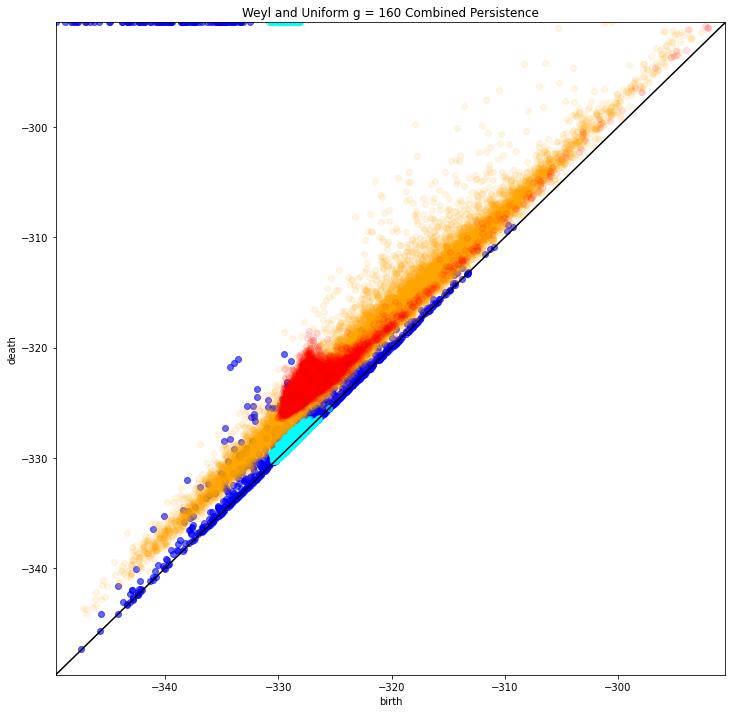

In [104]:

df_BigPersU = pd.read_csv('df_UnifBigPers_0.csv')
df_BigPersW = pd.read_csv('df_WeylBigPers_0.csv')

fig, ax = plt.subplots()

g=160

x0 = df_BigPersU[(df_BigPersU['index']==0)&(df_BigPersU['g']==g)]['birth'].values
y0 = df_BigPersU[(df_BigPersU['index']==0)&(df_BigPersU['g']==g)]['death'].values
x1 = df_BigPersU[(df_BigPersU['index']==1)&(df_BigPersU['g']==g)]['birth'].values
y1 = df_BigPersU[(df_BigPersU['index']==1)&(df_BigPersU['g']==g)]['death'].values

x2 = df_BigPersW[(df_BigPersW['index']==0)&(df_BigPersW['g']==g)]['birth'].values
y2 = df_BigPersW[(df_BigPersW['index']==0)&(df_BigPersW['g']==g)]['death'].values
x3 = df_BigPersW[(df_BigPersW['index']==1)&(df_BigPersW['g']==g)]['birth'].values
y3 = df_BigPersW[(df_BigPersW['index']==1)&(df_BigPersW['g']==g)]['death'].values

Mx= max(max(y0[y0!=np.inf]),max(y1[y1!=np.inf]))
mx = min(min(x0),min(x1),min(y0),min(y1))

y0[y0==np.inf]= Mx
y1[y1==np.inf]= Mx
y2[y2==np.inf]= Mx
y3[y3==np.inf]= Mx



ax.scatter(x0,y0,alpha=.6,c='blue') 
ax.scatter(x1,y1,alpha=.1,c='orange')                                 
ax.scatter(x2,y2,alpha=.6,c='cyan') 
ax.scatter(x3,y3,alpha=.1,c='red')                                 


x = np.linspace(mx,Mx,2000)


ax.plot(x,x,'k')

ax.set_title('Weyl and Uniform g = ' + str(g) + ' Combined Persistence')
ax.set_ylabel('death')
ax.set_xlabel('birth')

plt.xlim([mx, Mx])
plt.ylim([mx,Mx])

fig.set_size_inches(12, 12)



In [13]:
#Statistics from the TDA experiment

df_UnifNBigPers = pd.read_csv('df_UnifNBigPers_0.csv')
df_WeylNBigPers = pd.read_csv('df_WeylNBigPers_0.csv')

t = scipy.stats.t.interval(.99,df=99,loc=0,scale=1)
t = t[1]

df_SolnStats1 = pd.DataFrame()
for g in range(10,161,10):
    df1 = pd.DataFrame()
    UN0 = df_UnifNBigPers[df_UnifNBigPers['g']==g]['N0'].values
    
    Uavg = np.mean(UN0)
    Ustd = np.std(UN0)
    UE99 = Ustd*t/(len(UN0))**.5
    
    df1['g']=[g]
    df1['U N0 avg']=[str(Uavg)]
    df1['U 99% ME']=[str(round(UE99,2))]
    df_SolnStats1 = df_SolnStats1.append(df1,ignore_index=True)


    

In [15]:
df_SolnStats1.to_string()

<bound method DataFrame.to_string of       g U N0 avg U 99% ME
0    10     2.37     0.29
1    20     3.05     0.36
2    30     3.93     0.41
3    40     4.79     0.42
4    50     5.52     0.55
5    60     5.74     0.59
6    70     6.02     0.64
7    80     7.07     0.71
8    90     7.27     0.61
9   100     7.88     0.69
10  110     8.49      0.7
11  120     8.89     0.84
12  130     9.49      0.8
13  140    10.17     0.88
14  150     10.3     0.85
15  160    10.48     0.95>